<a href="https://colab.research.google.com/github/uomodellamansarda/PersonalGrowthTracker/blob/master/Workout_Analyzer_Eng_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is made to analyze Pomodoro Techniques Logs and undersand how well Data Science with Python practice is going. 
Practice could be study, no profit project, work, even reading a data book.

The goal is to reach 10.000 hours to be an expert. 
It's just a trivial proxy, but gives an idea and a direction and it's enough. 

The code is made to compare the efforts with a 3h daily ideal and costant practice. 

At the end of the code, after analyzed the past data as a report and feedback session, I made three estimation about the remaining time based on:

-Markov Inequality 

-Linear regression (I know that variables are not indipendently and identically distributed)

-Non Linear Regression using Prophet, an open source library developed by Facebook 

NOTE
If the time series is not stationary, or any of its possible trasformations you could not evaluate autocorrelation and partial correlation 

In the Year, Month, Week Analysis, I should create a logic that starts counting from the current day, instead at the moment it starts counting from the last log

#1 Library Setup


In [1]:
#Google Drive Pre-work
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
#importing all the necessary libraries 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import scipy.stats

#Autentication Section

In [3]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#DataLoading

In [4]:
#global variables of interest 

va='Python'
tvoi='Length'

#goal expressed in hours to be reached 
h=10000

#Link to the data source that is a csv file in drive
print("Please Insert the link to the Google Drive File")
namepath= input( )

id=namepath.split('/')[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  

# Dataset is now stored in a Pandas Dataframe
csvname="Filename.csv"
#read the csv
#The number of columns from the app csv file is known	
columns_name=['Year', 'Month', 'Day', 'Time', 'Length', 'Start', 'End', 'Activity']
dfraw=pd.read_csv(csvname,names=columns_name,sep=',',skiprows=1,skipfooter=0, index_col=False)
print("Printing the data type of the time variable:")
print(type(dfraw[tvoi].iloc[0]))
dfraw[tvoi] = dfraw[tvoi].astype('str')
#We throw away time variables longer than 6 characters
# 00:00:00 if there is any variable 
# longer should be an error
mask = (dfraw[tvoi].str.len() == 6) 
dfraw = dfraw.loc[mask]
#removing all the white spaces
dfraw[tvoi]=dfraw[tvoi].str.strip()
#Converting to datetime datatype the time column
dfraw[tvoi]=pd.to_datetime(dfraw[tvoi], format='%M:%S')
#Merging in one date thre columns containing
#Year Month Day Informations
dfraw['Date'] = dfraw.apply(lambda row: datetime(row['Year'], row['Month'], row['Day']), axis=1)


Please Insert the link to the Google Drive File
https://drive.google.com/file/d/1m9XlRgtK-n-r3piu4mClUwIz0xJETIIg/view?usp=sharing
Printing the data type of the time variable:
<class 'str'>


In [5]:

#The code extracts all the logs containing the Python
#or python word
dfraw[['main_activity','sub_activity']]=dfraw['Activity'].str.split('@', 1,expand=True)
pythondf_raw=dfraw[(dfraw['Activity'].str.contains("Python",na=False)) | (dfraw['Activity'].str.contains("python",na=False))] 


## Resampling

In [6]:
#We create a copy of 
#the dataframe containing only the 
#python records and
#we aggregate on daily basis 


rs_df=pythondf_raw.groupby('Date').count().copy()
#We resample the dataframe in order to have 
#a continues time series 
#with daily frequency
#we fill missing values with 0
rs_df=rs_df.resample('D').asfreq().fillna(0)
#divide by 2 because each pomodoro record lasts 25 minutes
#and we create a new column to keep track of that
#NOTE!
#this transformation is needed 
#only for the Actual cumulated column
#not for the ideal one already expressed in terms of hours  
rs_df['Cum']=rs_df['Activity'].cumsum().divide(2)
#3 hours is the minimum ideal time to find during the day
#to practice with python 
#ideally with 3 hours a day 
#you will become a python expert after 9 years
rs_df['Costant_CUM']=3
rs_df['Costant_CUM']=rs_df['Costant_CUM'].cumsum()


#Hours Remaining to be an expert

In [7]:
#Max Hours 

max_hours=rs_df['Cum'][-1]
first_thous=rs_df[rs_df['Cum']>=1000].head(1)
second_thous=rs_df[rs_df['Cum']>=2000].head(1)
print("Total hours Dedicated until now",max_hours)
remaining_h=h-max_hours
print("Remaining hours to became an expert: \n",remaining_h)
print(type(rs_df.index[0]))
print()
print("First 1000",first_thous)
print("Second 1000",second_thous)
print("X_days")
x_days=[rs_df.index[0],first_thous.index[0],second_thous.index[0],rs_df.index[-1]]
x_days_label=[x.strftime("%d/%m/%Y") for x in x_days]
print(x_days)
print(x_days_label)
#Extracting last value and converting to an int
progress=int(round(rs_df.Cum[-1],0))
print(progress)

Total hours Dedicated until now 3319.5
Remaining hours to became an expert: 
 6680.5
<class 'pandas._libs.tslibs.timestamps.Timestamp'>

First 1000             Year  Month   Day  ...  sub_activity     Cum  Costant_CUM
Date                           ...                                   
2018-11-11  22.0   22.0  22.0  ...          22.0  1000.5         1401

[1 rows x 12 columns]
Second 1000             Year  Month   Day  ...  sub_activity     Cum  Costant_CUM
Date                           ...                                   
2020-02-28  18.0   18.0  18.0  ...          18.0  2000.0         2823

[1 rows x 12 columns]
X_days
[Timestamp('2017-08-02 00:00:00', freq='D'), Timestamp('2018-11-11 00:00:00', freq='D'), Timestamp('2020-02-28 00:00:00', freq='D'), Timestamp('2021-03-08 00:00:00', freq='D')]
['02/08/2017', '11/11/2018', '28/02/2020', '08/03/2021']
3320


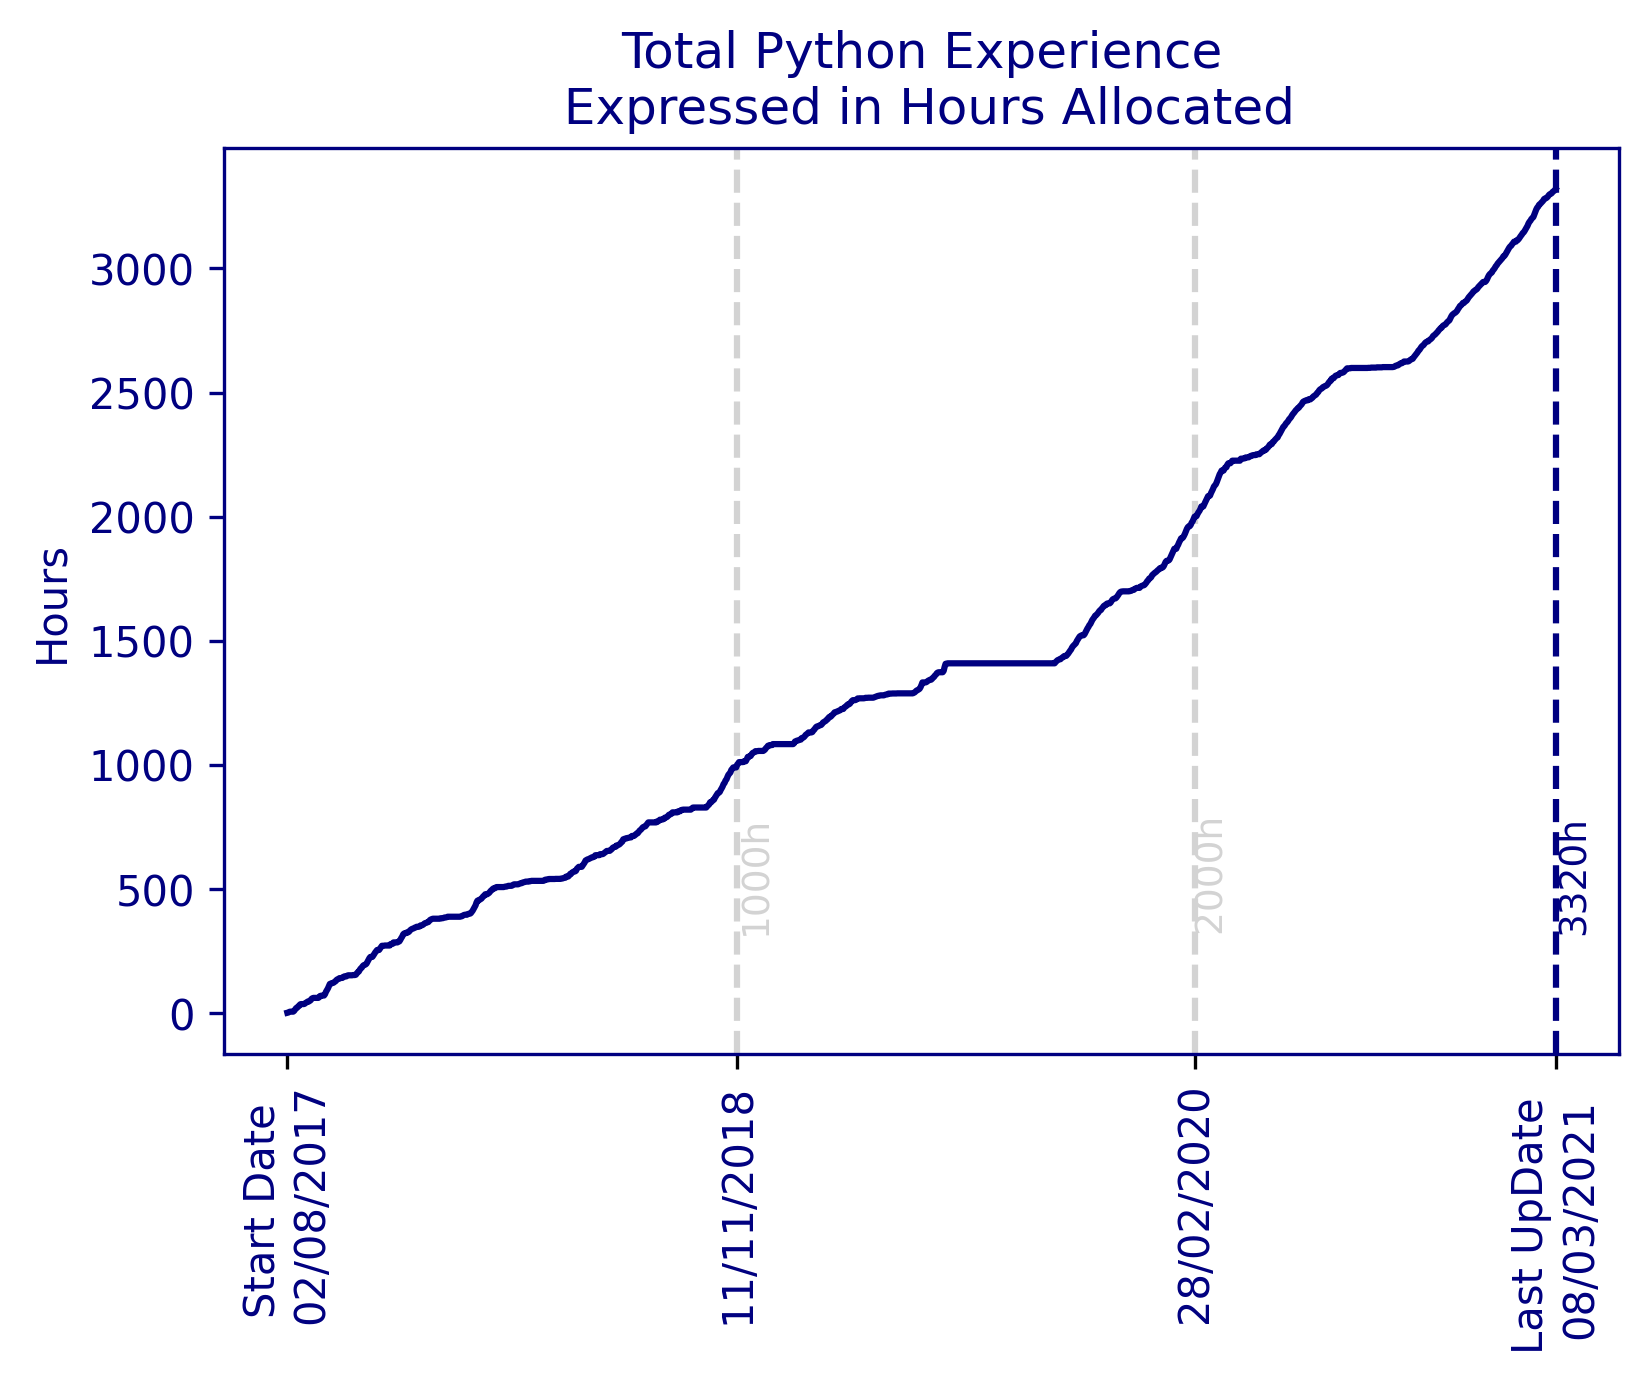

In [8]:
fig2, ax2= plt.subplots(figsize=(6,4),
                          facecolor='white', dpi=300)
#We plot and compare the actual trend
#with the ideal    
plt.axvline(first_thous.index,linestyle="dashed",color='lightgrey')
plt.axvline(second_thous.index,linestyle="dashed",color='lightgrey')

plt.axvline(rs_df.index[-1],linestyle="dashed",color='navy')
ax2.plot(rs_df.index,rs_df['Cum'],color='navy')
ax2.set_xticks([x_days[0],x_days[1],x_days[2],x_days[3]])
ax2.tick_params(axis='y', colors='navy')
ax2.set_xticklabels(["Start Date \n{}".format(x_days_label[0]),x_days_label[1],x_days_label[2],"Last UpDate \n{}".format(x_days_label[3])], rotation=90,color="navy")
#ax2.set_yticklabels(color="navy")
ax2.set_title('Total Python Experience\n Expressed in Hours Allocated',color="navy")

limit=ax2.get_ylim()
mid=limit[1]*0.10
text=plt.text(x_days[1],mid,'1000h',fontsize=9,rotation=90,
              color="lightgrey"
             )
text2=plt.text(x_days[2],mid,'2000h ',fontsize=9,rotation=90,
               color="lightgrey")
text2=plt.text(x_days[-1],mid,"{}h".format(progress),fontsize=9,rotation=90,
               color="navy")
ax2.set_ylabel("Hours",color='navy')
ax2.spines['bottom'].set_color('navy')
ax2.spines['top'].set_color('navy') 
ax2.spines['right'].set_color('navy')
ax2.spines['left'].set_color('navy')
plt.show()


#Plotting Functions

In [9]:
#We create a function 
#in order to plot all the hours dedicated to the 
#Variable of Interest (in this specific case python)
#And we compare with the "hours per day  goal"

def practice_plot(df):
  #maxh will stores the maximum cumulated hours 
  #actually dedicated
  #to the goal 
  maxh=df.Cum.max()
  #maxc will stores the maximum cumulated hours 
  #ideally dedicated
  #to the goal (3h per week since started studying python) 
  maxc=df.Costant_CUM.max()
  print("Max Hours of practice with ",va, " is %d h"%maxh)
  delta=maxh-maxc
  print("Python Logs starts",rs_df.index[0].date(), "and they end",rs_df.index[-1].date())
  print("The difference between the actual cumulated hours and the ideal cumulated hours is: %s hours \n"%delta)

  def plotting(df):
    fig, ax= plt.subplots(figsize=(15,10),
                          facecolor='white', dpi=300)
    #We plot and compare the actual trend
    #with the ideal    
    ax.plot(df.index,df['Cum'])
    ax.plot(df.index,df['Costant_CUM'],'g--')
    ax.tick_params(axis='x',rotation=90)
    ax.set(title='Total Hours Studying and Working With Python (%d H)'%(maxh))
    plt.show()
    return 
#We can give to the function
#different DataFram
#We must be aware if they are 
#longer or shorter of 180/90/30 days    
  if len(df)>180:
    #Windows length expressed in days 
    #30 90 180 days               
    delta_mens=[-30,-90,-180]
    delta_mens_pos=res =[abs(ele) for ele in delta_mens]
    delta_mens_dic={"Monthly":-30,"Quarter":-90,"Semester":-180}
    z=df['Cum'].iloc[-1]
    y=df['Costant_CUM'].iloc[-1]

    percentage_change=[(((maxh-maxc)/(df['Cum'].iloc[x]-df['Costant_CUM'].iloc[x]))*100).round(2) for x in delta_mens]
    for c,value in enumerate(percentage_change):
      #we need this section in order to 
      #deal when the ratio is >0 or <0
      #this will happens when both numerator
      #and denominator will be >0
      
      if value<0:
        
        percentage_change=round(value-100,2)
        print("Spread between Ideal and Actual hours reduced by %s  in the past %s days "%(percentage_change,delta_mens_pos[c]))
      elif value>0: 
         
        percentage_change=round(100-value,2)
        print("Spread between Ideal and Actual hours reduced by %s  in the past %s days "%(percentage_change,delta_mens_pos[c]))    
      else:
        print('Something went wrong my friend!')
    plotting(df)    
  elif len(df)>90:
      delta_mens=[-30,-90]
      delta_mens_pos=res =[abs(ele) for ele in delta_mens]
      delta_mens_dic={"Monthly":-30,"Quarter":-90}
      percentage_change=[(((maxh-maxc)/(df['Cum'].iloc[x]-df['Costant_CUM'].iloc[x]))*100).round(2) for x in delta_mens]
      
      for c,value in enumerate(percentage_change):
        
      #we need this section in order to 
      #deal when the ratio is >0 or <0
      #this will happens when both numerator
      #and denominator will be >0
        if value<0:
          percentage_change=round(value-100,2)
          print("Spread between Ideal and Actual hours reduced by %s  in the past %s days "%(percentage_change,delta_mens_pos[c]))
        elif value>0:         
          percentage_change=round(100-value,2)
          print("Spread between Ideal and Actual hours reduced by %s  in the past %s days "%(percentage_change,delta_mens_pos[c]))    
        else:
          print('Something went wrong my friend!')
      plotting(df)    
      
      
  elif len(df)<90:
    #if the length is smaller than a quarter 
    #we don't compute the relative ratio
      plotting(df)
    
    

#Since Ever Plot

Max Hours of practice with  Python  is 3319 h
Python Logs starts 2017-08-02 and they end 2021-03-08
The difference between the actual cumulated hours and the ideal cumulated hours is: -625.5 hours 

Spread between Ideal and Actual hours reduced by 8.82  in the past 30 days 
Spread between Ideal and Actual hours reduced by 20.82  in the past 90 days 
Spread between Ideal and Actual hours reduced by 22.35  in the past 180 days 


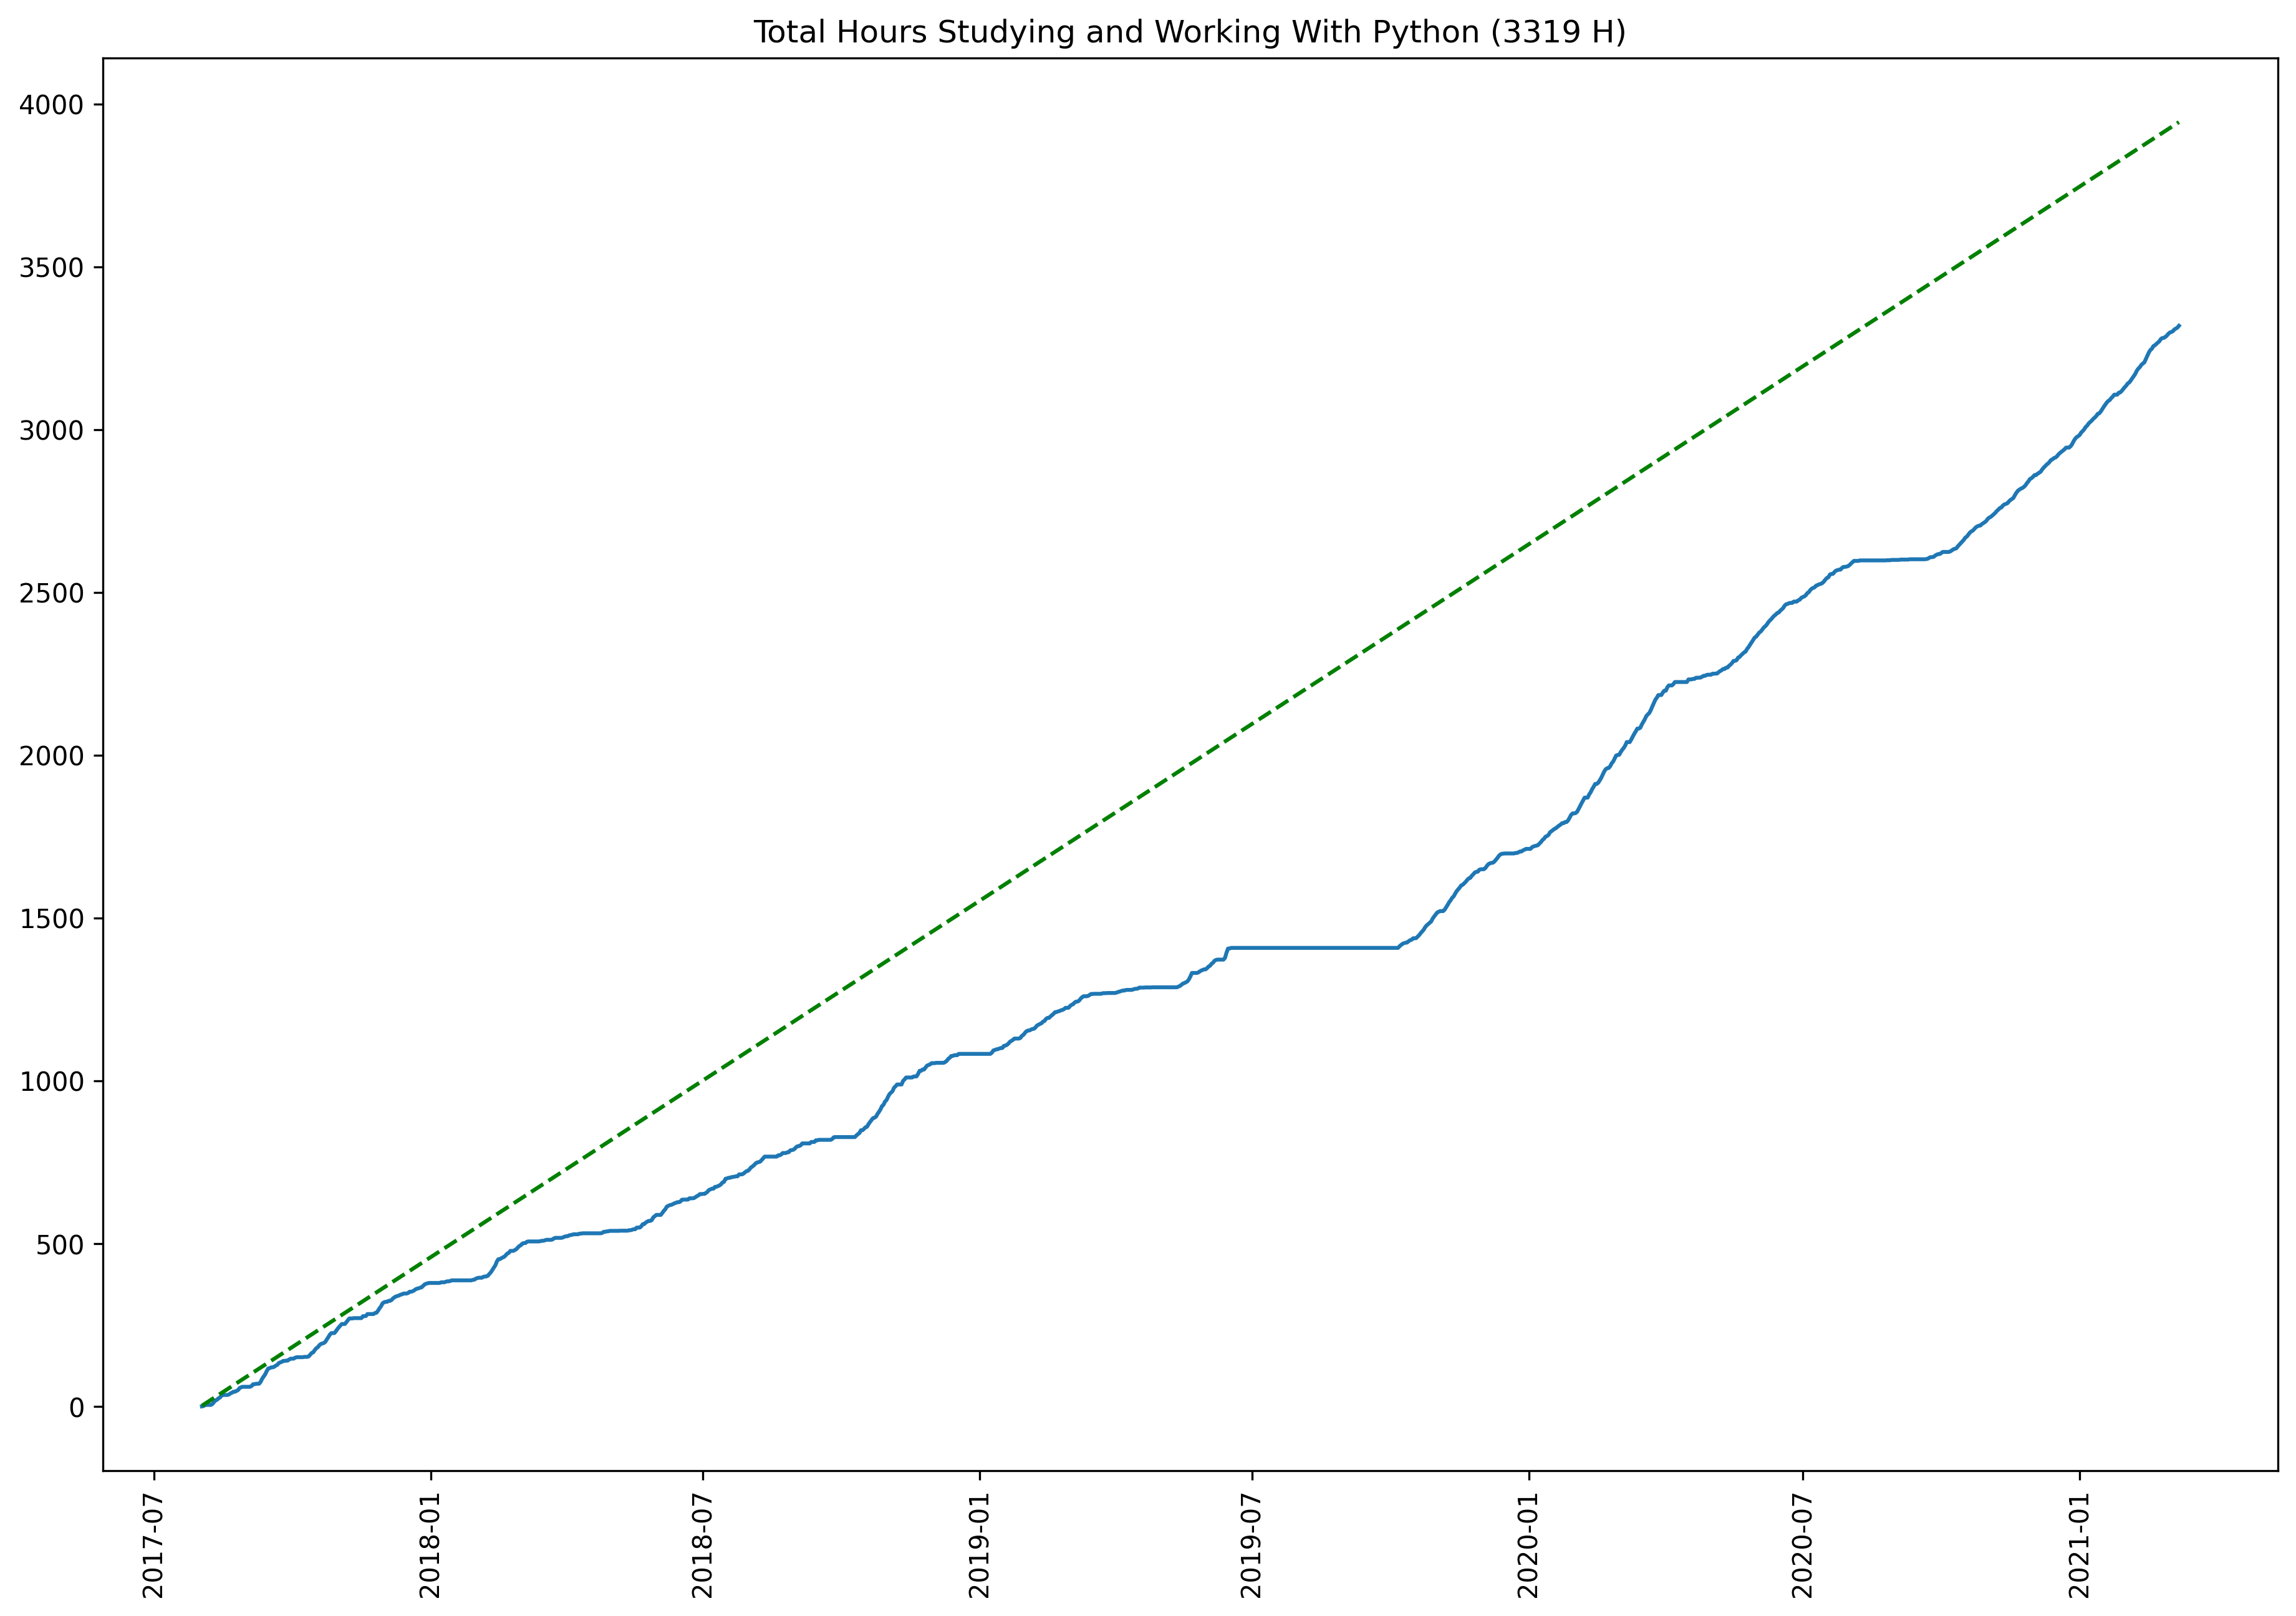

In [10]:
practice_plot(rs_df)

#Current Year Analysis

In [11]:
#we create a copy in order to modify without 
#corrupting the original df
#containing all the records 
#of the selected activity
#grouped by day 
pythondf=rs_df
#this is a test for timeseries slicing
print("Slicing test for current year \n", pythondf['2020'].tail())
print(pythondf.head())
print(pythondf.index[1:10])
#here you can put automatically the year
select_Year='2021'
start=-365
print(len(pythondf.iloc[start:]))

Slicing test for current year 
             Year  Month   Day  ...  sub_activity     Cum  Costant_CUM
Date                           ...                                   
2020-12-27  13.0   13.0  13.0  ...          13.0  2956.0         3732
2020-12-28  18.0   18.0  18.0  ...          18.0  2965.0         3735
2020-12-29  15.0   15.0  15.0  ...          15.0  2972.5         3738
2020-12-30  10.0   10.0  10.0  ...          10.0  2977.5         3741
2020-12-31   6.0    6.0   6.0  ...           6.0  2980.5         3744

[5 rows x 12 columns]
            Year  Month  Day  ...  sub_activity  Cum  Costant_CUM
Date                          ...                                
2017-08-02   2.0    2.0  2.0  ...           2.0  1.0            3
2017-08-03   2.0    2.0  2.0  ...           2.0  2.0            6
2017-08-04   5.0    5.0  5.0  ...           5.0  4.5            9
2017-08-05   2.0    2.0  2.0  ...           2.0  5.5           12
2017-08-06   0.0    0.0  0.0  ...           0.0  5.5       

##Average Time Analysis

In [12]:
#here we could compare the last y years 
tot_hours=rs_df[select_Year]['Cum'][-1]-rs_df[select_Year]['Cum'][0]
len_selected_y=len(rs_df[select_Year])
average=(tot_hours/len_selected_y).round(2)
starting_day=rs_df[select_Year].index[0].date()
print('Total Hours since:', starting_day)
print((tot_hours).round(2))
print('Daily Average Hours:', starting_day)
print(average,'\n')



Total Hours since: 2021-01-01
335.5
Daily Average Hours: 2021-01-01
5.01 



#-365 Plot 

Max Hours of practice with  Python  is 3319 h
Python Logs starts 2017-08-02 and they end 2021-03-08
The difference between the actual cumulated hours and the ideal cumulated hours is: -625.5 hours 

Spread between Ideal and Actual hours reduced by 8.82  in the past 30 days 
Spread between Ideal and Actual hours reduced by 20.82  in the past 90 days 
Spread between Ideal and Actual hours reduced by 22.35  in the past 180 days 


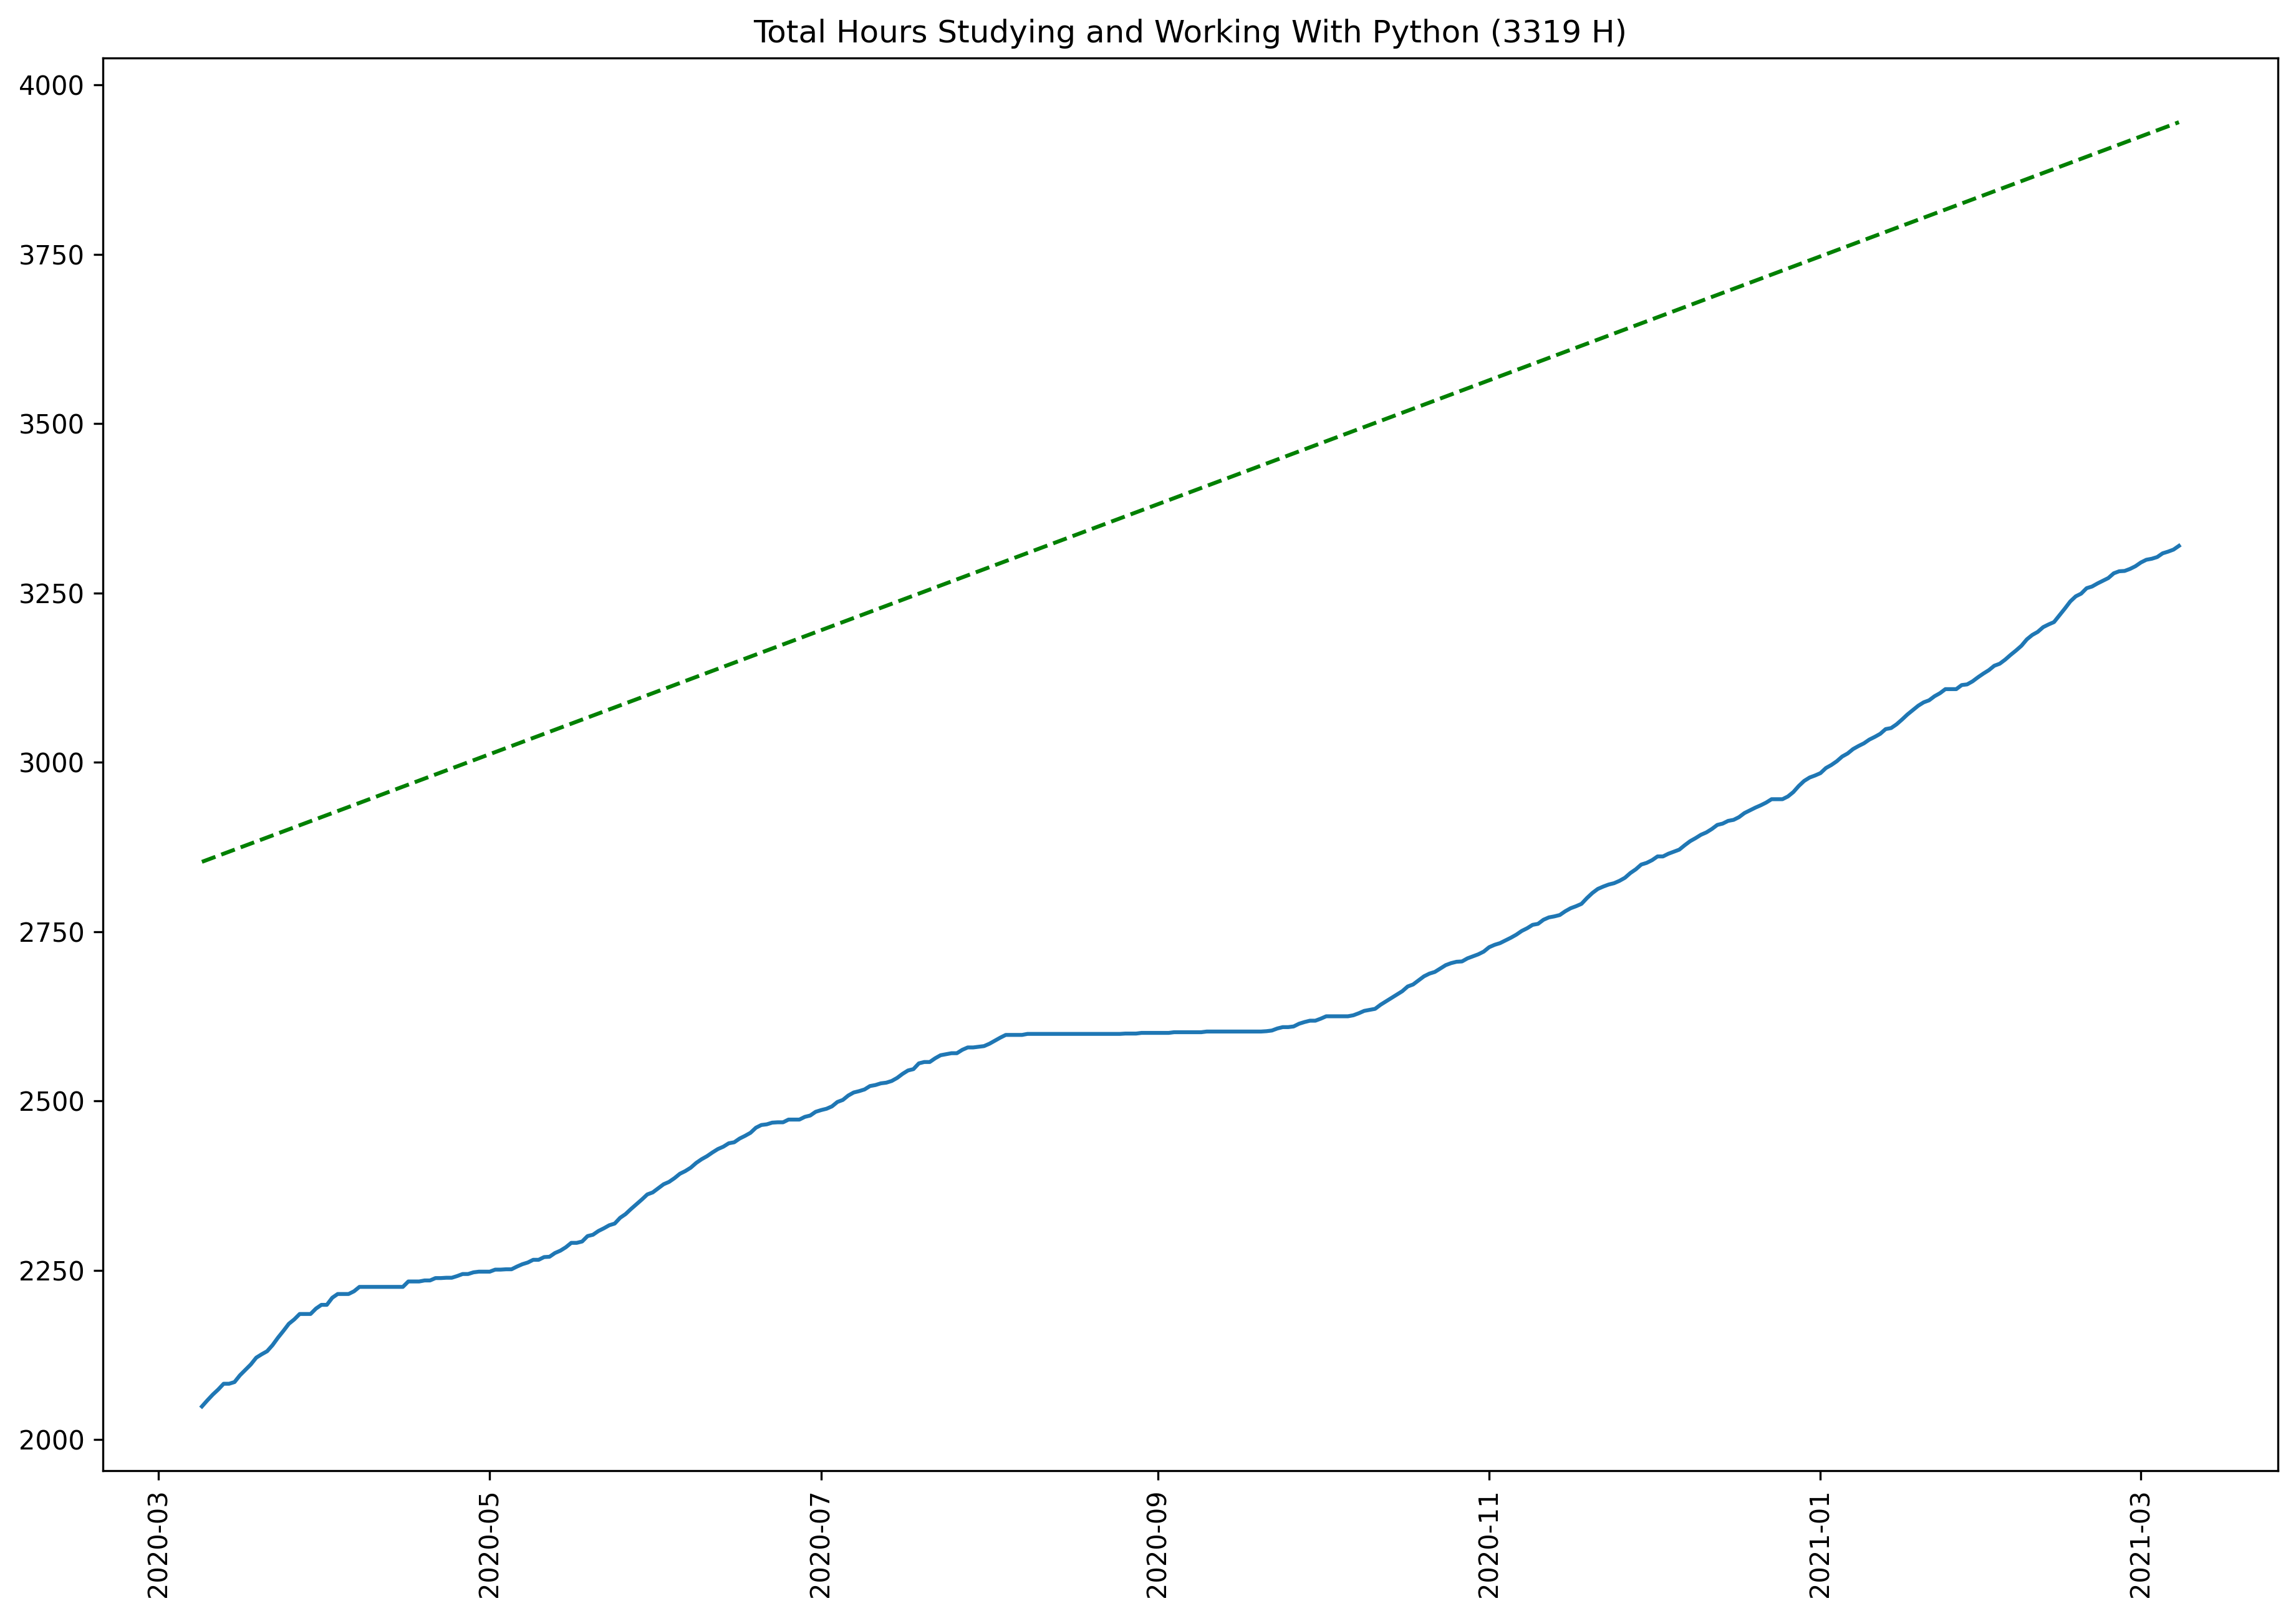

In [13]:
practice_plot(rs_df.iloc[start:])

#Current Year Analysis 

In [14]:
#we create a 
#current day vector 
#current month vector (int)
#current year vector (int)
today=datetime.now()
actual_month=today.month
actual_year=today.year
print(type(actual_year))

#we convert to string 
#current year vector 
year_str=str(actual_year)
d=1
#we create
#a starting point 
#for current year  
#that is the 1 of January
date2=datetime(actual_year,1,1)

#we create a 
#current month threshold 
filtering_threshold=datetime(actual_year,actual_month,d)
#we filter 
#the python activities df
#based on the current month 
python_act_m=pythondf[pythondf.index>=filtering_threshold]

#we filter 
#the python activities df
#based on the current year
python_act_y=pythondf[pythondf.index>=year_str]
#we calculate
#the numbers of days 
#from
#the beginning of the month 
#and the current day 
d_day=(today-filtering_threshold).days
#we calculate
#the numbers of days 
#from
#the beginning of the year
#and the current day 
d_y_day=(today-date2).days

print('Python monthly head \n', python_act_m.head())
print('Python yearly head \n', python_act_y.head())


<class 'int'>
Python monthly head 
             Year  Month   Day  ...  sub_activity     Cum  Costant_CUM
Date                           ...                                   
2021-03-01  11.0   11.0  11.0  ...          11.0  3295.0         3924
2021-03-02   8.0    8.0   8.0  ...           8.0  3299.0         3927
2021-03-03   3.0    3.0   3.0  ...           3.0  3300.5         3930
2021-03-04   5.0    5.0   5.0  ...           5.0  3303.0         3933
2021-03-05  11.0   11.0  11.0  ...          11.0  3308.5         3936

[5 rows x 12 columns]
Python yearly head 
             Year  Month   Day  ...  sub_activity     Cum  Costant_CUM
Date                           ...                                   
2021-01-01   7.0    7.0   7.0  ...           7.0  2984.0         3747
2021-01-02  15.0   15.0  15.0  ...          15.0  2991.5         3750
2021-01-03   9.0    9.0   9.0  ...           9.0  2996.0         3753
2021-01-04  11.0   11.0  11.0  ...          11.0  3001.5         3756
2021-01-05

Max Hours of practice with  Python  is 3319 h
Python Logs starts 2017-08-02 and they end 2021-03-08
The difference between the actual cumulated hours and the ideal cumulated hours is: -625.5 hours 



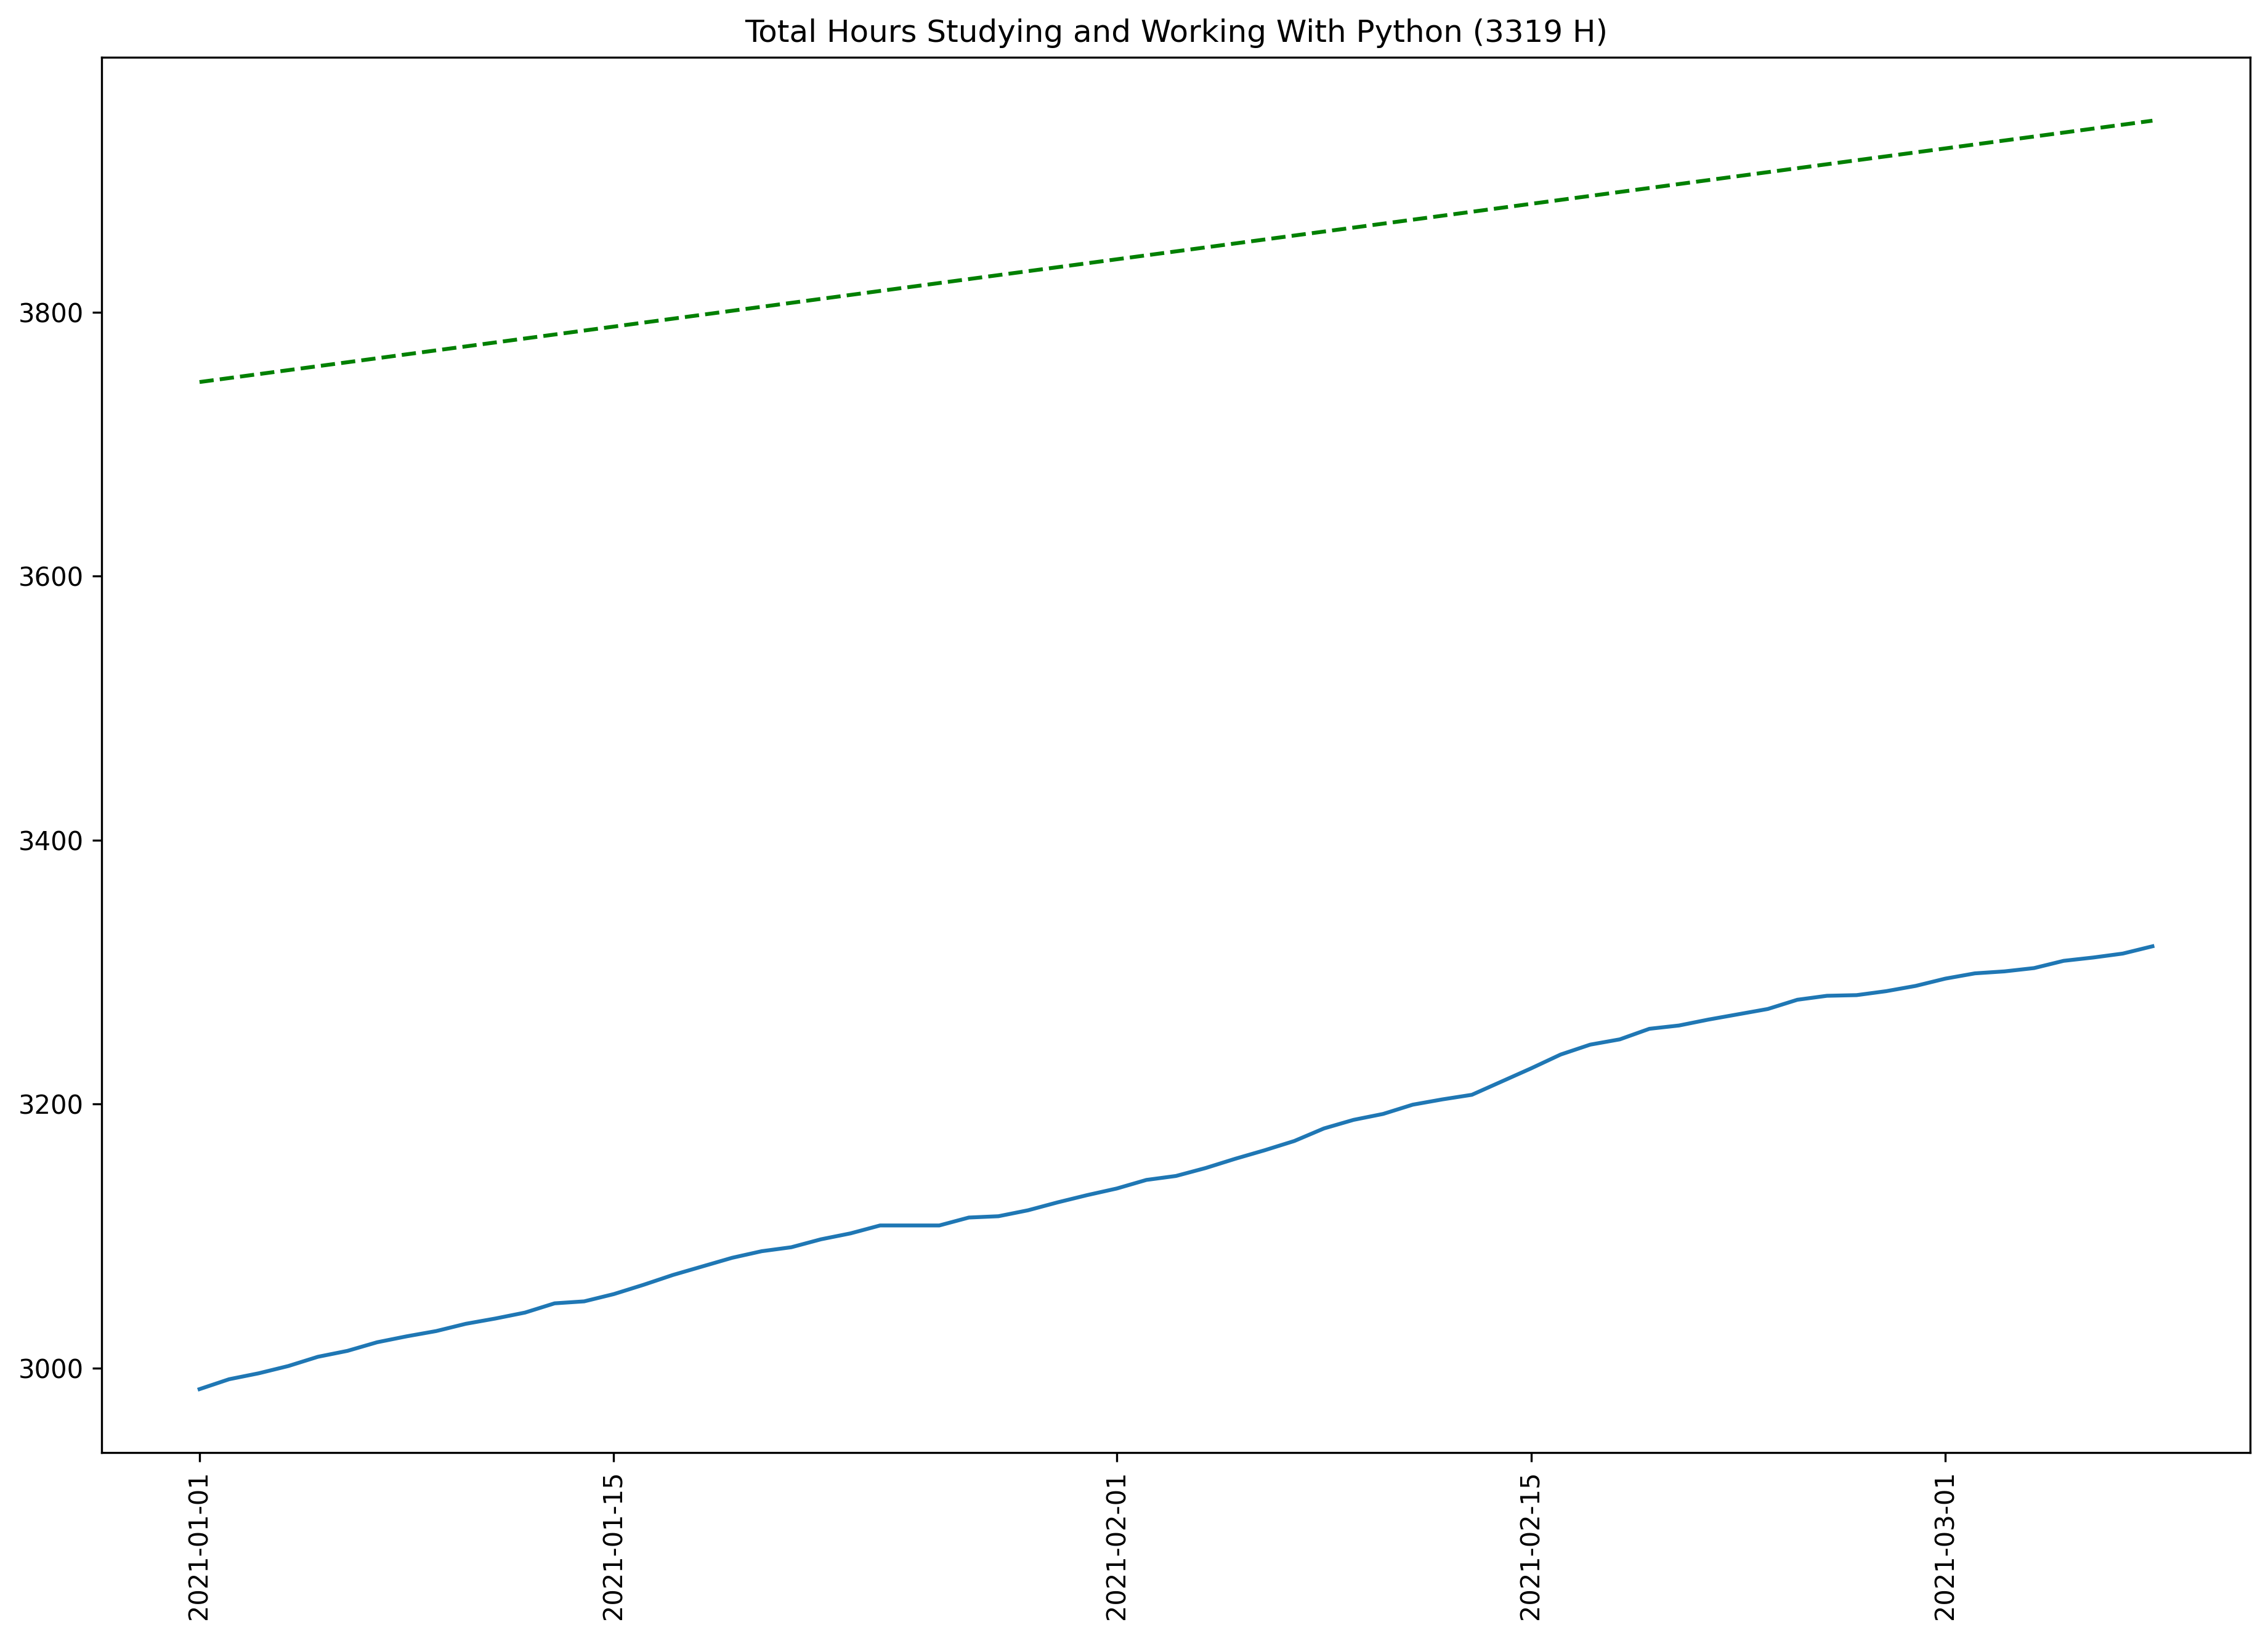

In [15]:
practice_plot(python_act_y)

In [16]:
#This is a relative plot in order 
#to analyze the learning trend 
#relative to 
#the current year 
#current month 
def relative_plot(df,date): 
    #we filter the data frame based on date
    f_df=df[date::].copy()
    #we calculate the actual relative cumulated column
    f_df['R_Cum']=f_df['Activity'].cumsum().divide(2)
    #here we create the ideal relative cumulated column 
    f_df['R_Costant_CUM']=np.arange(3,len(f_df)*3+1,3)
    #here we extract the relative value 
    #of the ideal and real cumulated function
    maxh=f_df.R_Cum.max()
    maxc=f_df.R_Costant_CUM.max()

    print("Python Practice since",date," are %s h"%maxh)
    #spread between the two maximum values 
    delta=maxh-maxc
    print("The relative spread between the ideal and the actual hours is equal to %s h"%delta)
    #Plotting the results 
    fig, ax= plt.subplots(facecolor='white', dpi=300)
    ax.plot(f_df.index,f_df['R_Cum'])
    ax.plot(f_df.index,f_df['R_Costant_CUM'],'g--')
    ax.tick_params(axis='x',rotation=90)
    ax.set(title='Relative Hours Studying and Working With Python (%d H)'%(maxh))
    
    plt.show()
    return 

Python Practice since 2021  are 339.0 h
The relative spread between the ideal and the actual hours is equal to 138.0 h


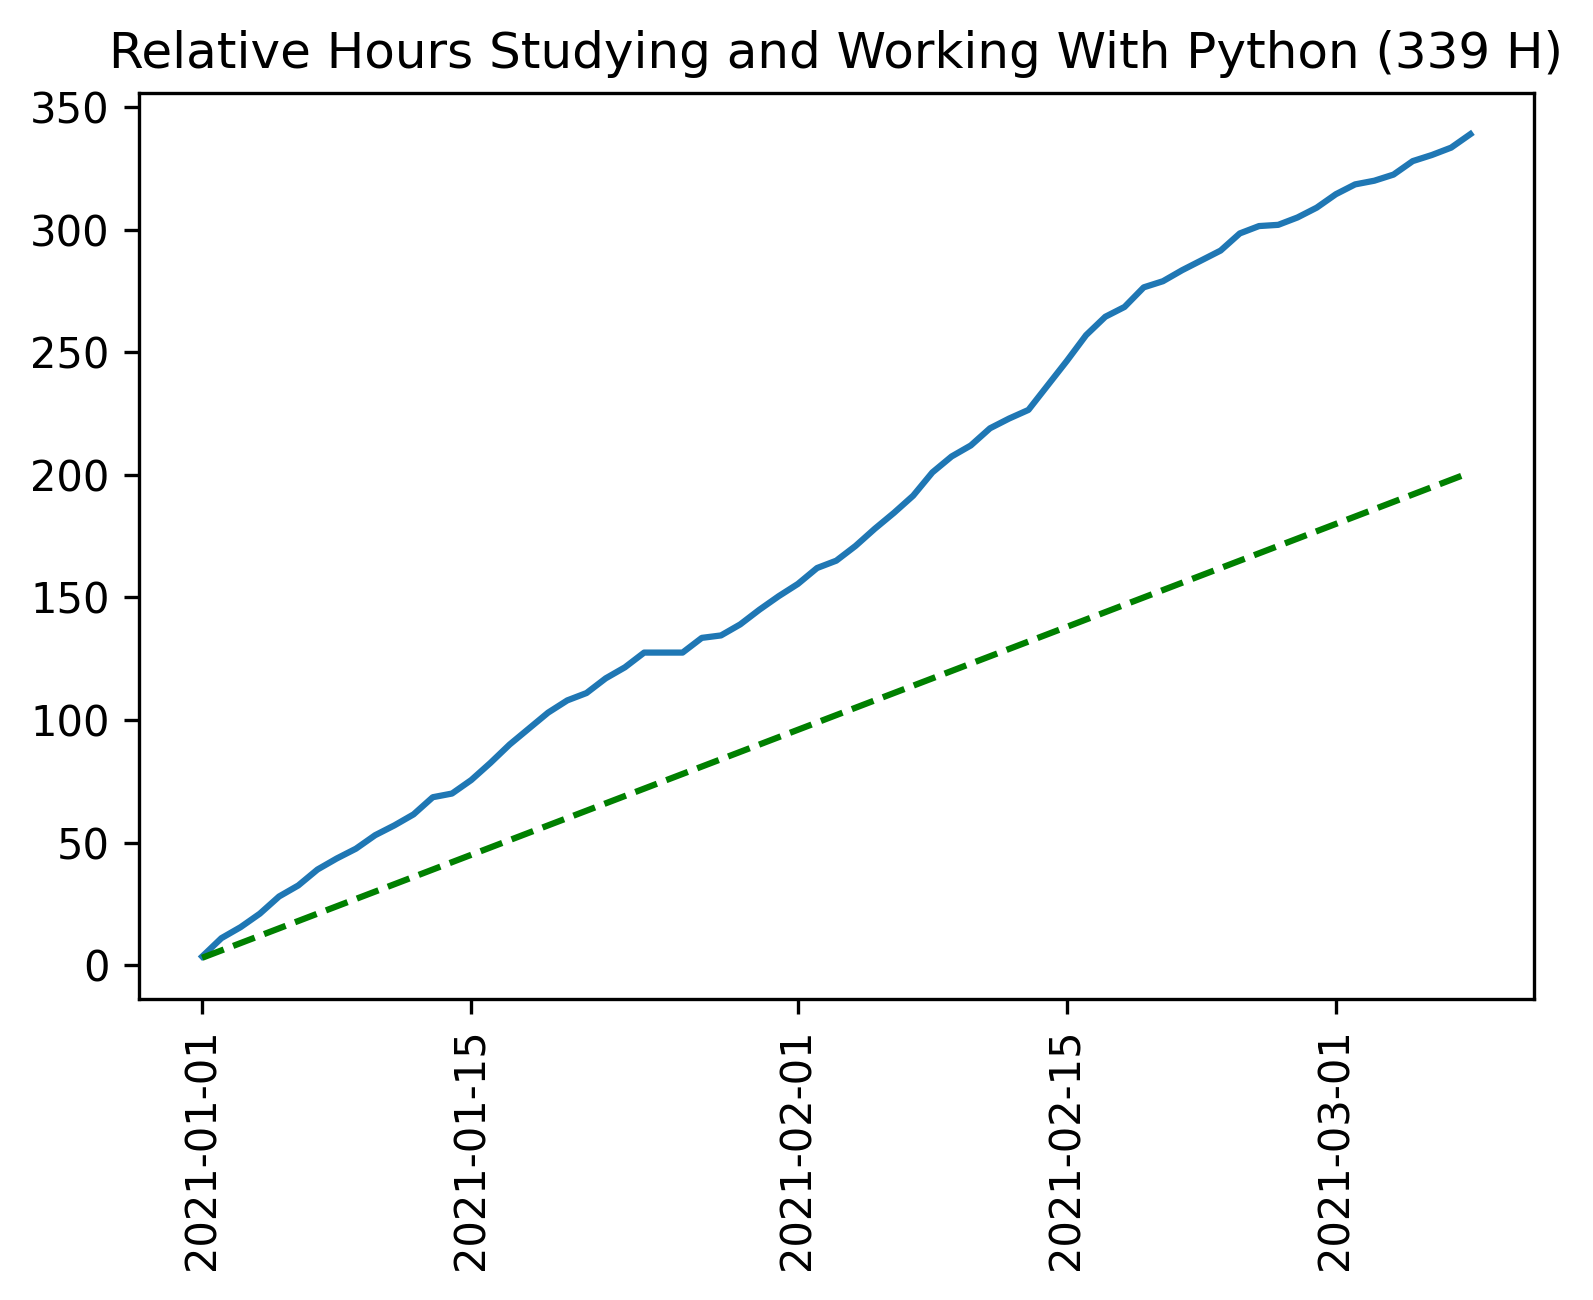

In [17]:
year='2021'
relative_plot(rs_df,year)

In this section we analyze how we are performing on monthly basis and on yearly basis
We should select manually the month and the year, this way is also possible to go back to any month 

In [18]:
month='2021-01'

Python Practice since 2021-01  are 339.0 h
The relative spread between the ideal and the actual hours is equal to 138.0 h


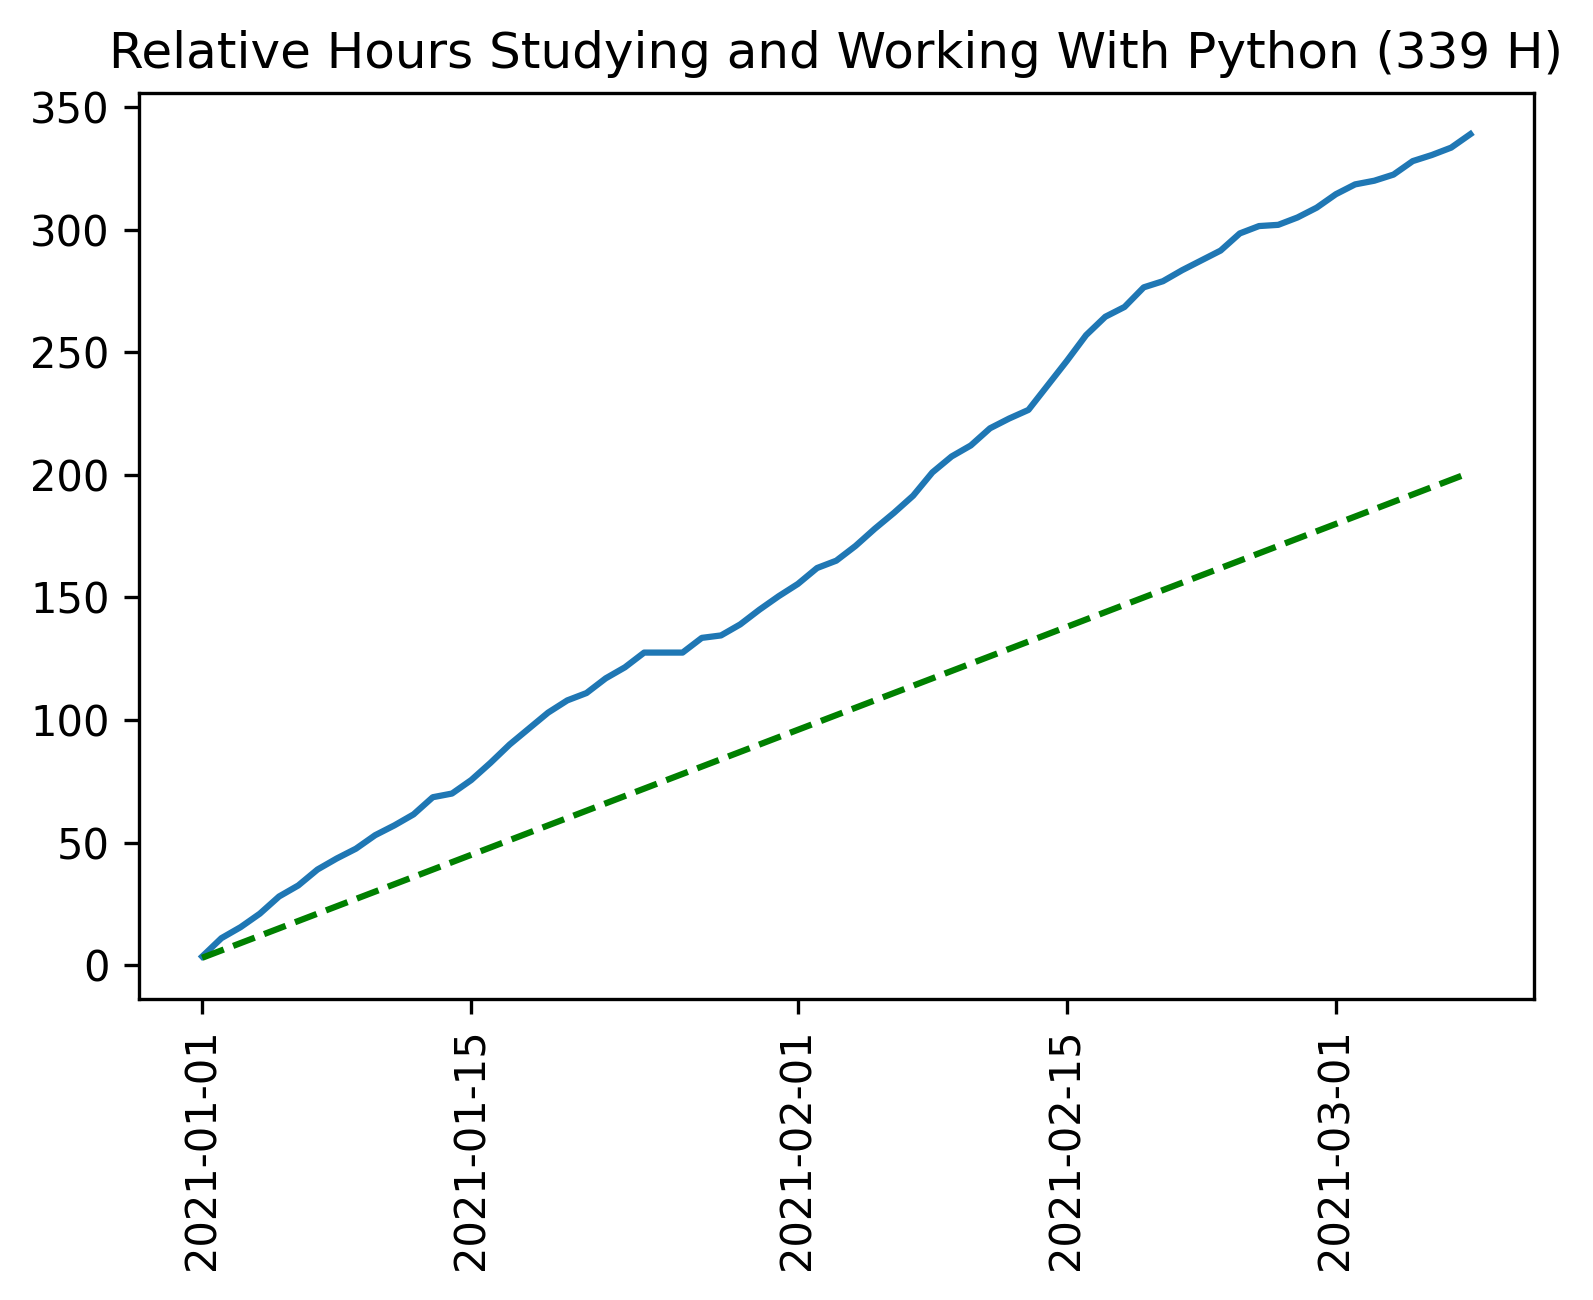

In [19]:
relative_plot(rs_df,month)

Max Hours of practice with  Python  is 3319 h
Python Logs starts 2017-08-02 and they end 2021-03-08
The difference between the actual cumulated hours and the ideal cumulated hours is: -625.5 hours 



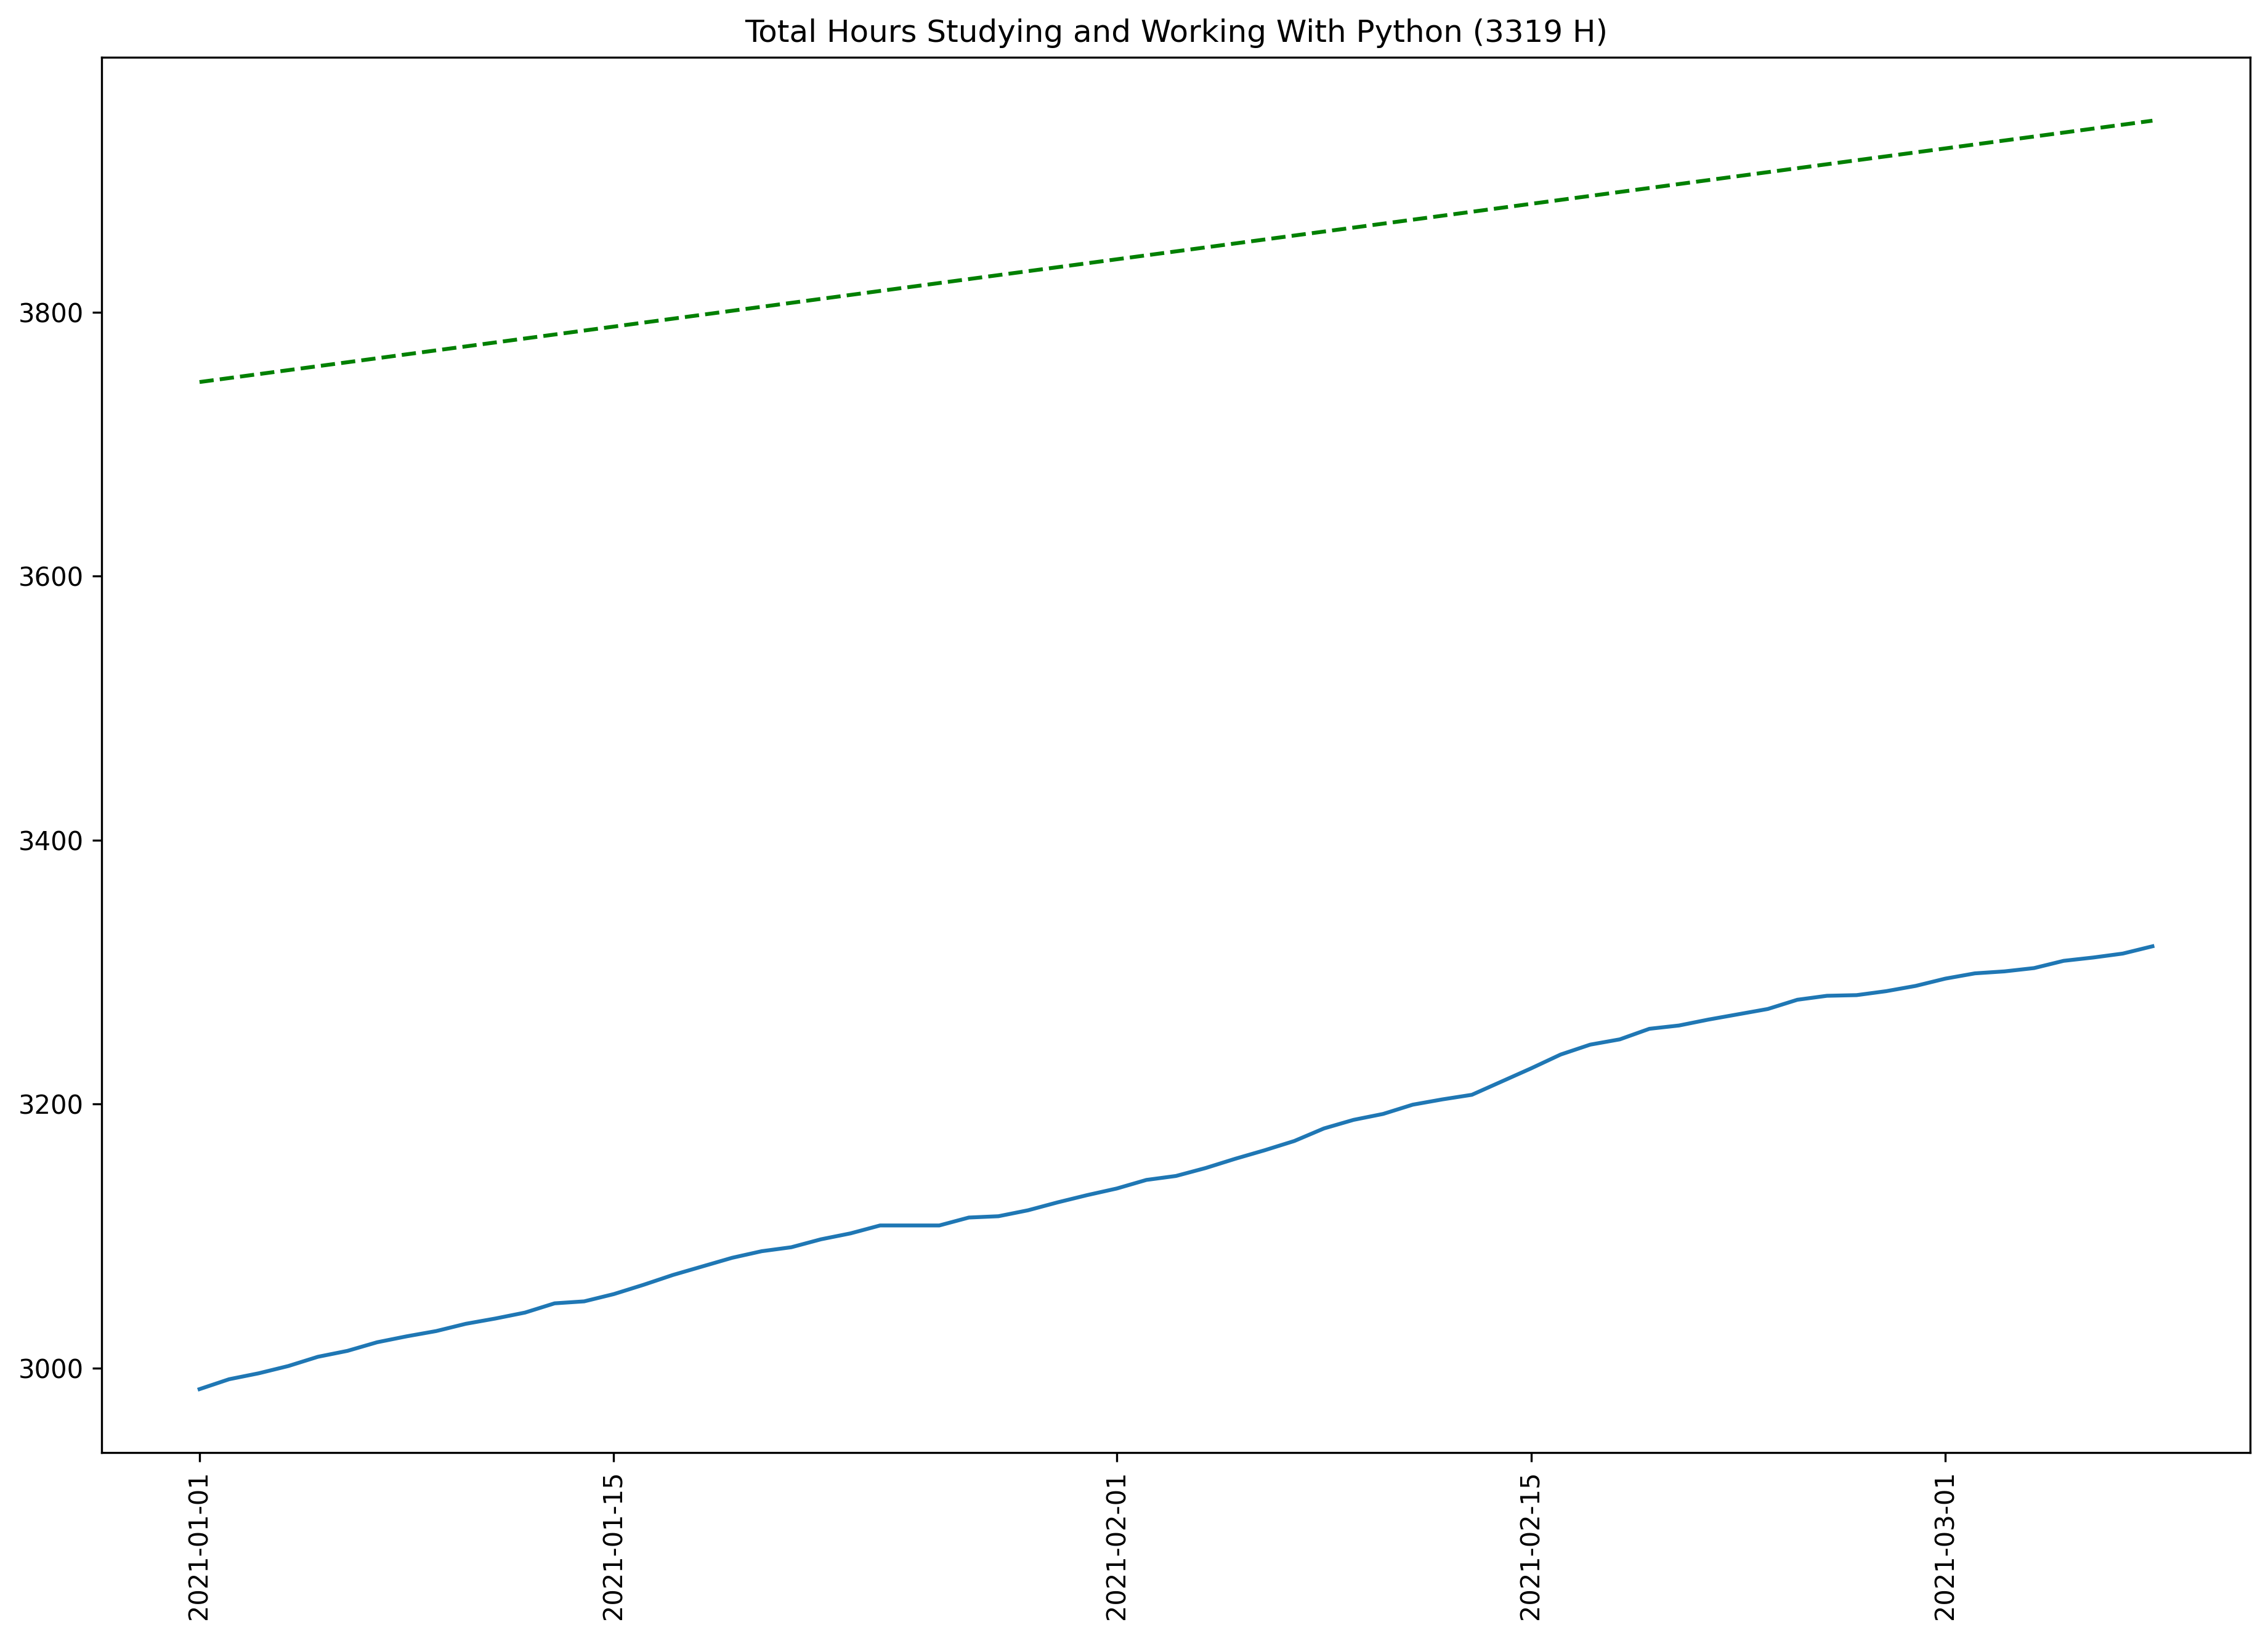

Python Practice since 2021  are 339.0 h
The relative spread between the ideal and the actual hours is equal to 138.0 h


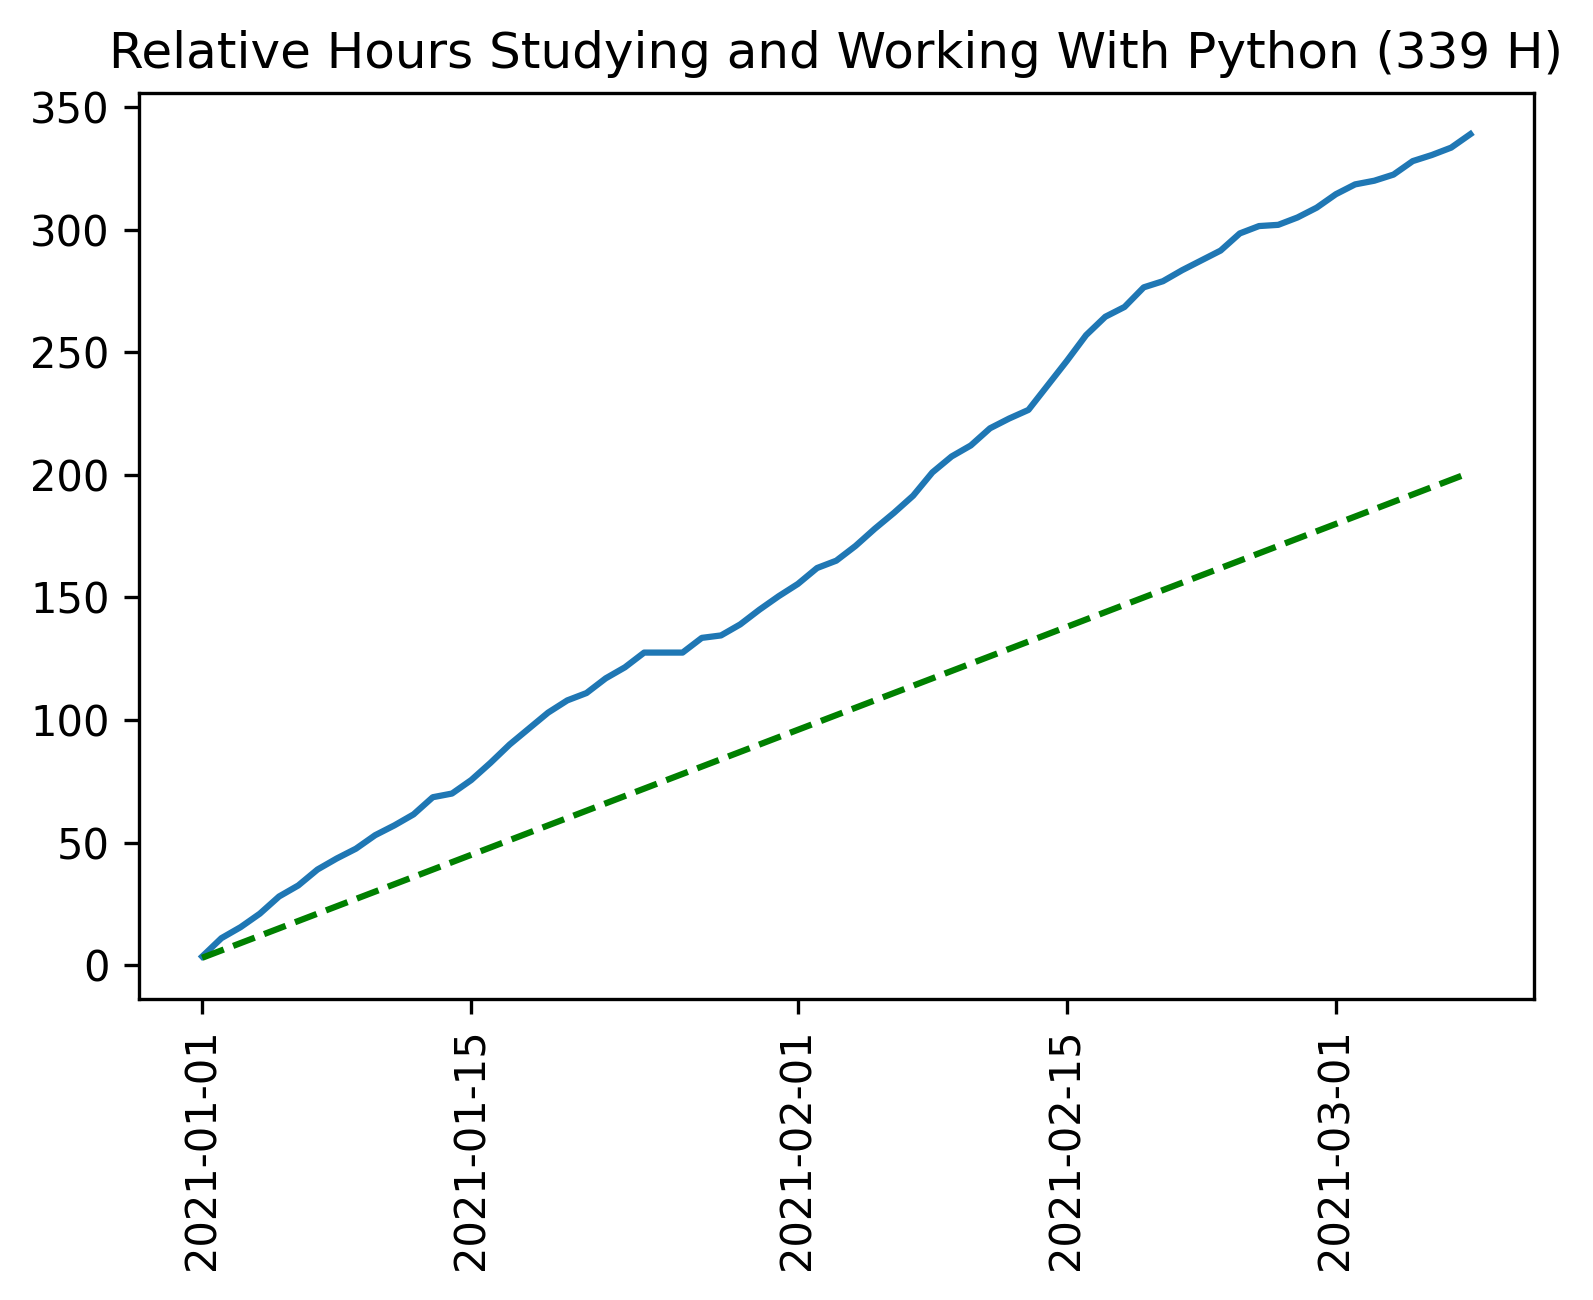

In [20]:
practice_plot(python_act_y)
relative_plot(rs_df,year)

#Goal Forcasting 

In this section we start analyzing the time series, also for a self-learning reason, in order to get some information about future 

#DON'T TRY THIS AT HOME

We will develop some estimations based on: 

*   Normal Gaussian Distribution
*   Markov Inequality
*   Moving average
*   Non stationary process
    

Don't be scared about my choice, I know that is a strong assumption and is not true, but i will consider days as Independent and Identically Distributed 



In [21]:
#we never trasformed and replaced Activity 
#from half hours to hours
#we have done a trasnformation referring 
#to the Actual Cumulative column
#so we need in order to have an hourly idea
#to divide by two the activity column
#rs_df contains all the python logs since they were recorded
activity_divided=rs_df.Activity.divide(2)
print("Printing Selected Activity Mean:")
print(round(activity_divided.mean(),2))
print("Printing Selected Activity STD:")
print(round(activity_divided.std(),2))
print("Printing Selected Activity Median:")
print(round(activity_divided.median(),2))
print("Printing activity_divided DataFram basic stats:")
print(activity_divided.describe().round(2))

Printing Selected Activity Mean:
2.52
Printing Selected Activity STD:
2.78
Printing Selected Activity Median:
1.5
Printing activity_divided DataFram basic stats:
count    1315.00
mean        2.52
std         2.78
min         0.00
25%         0.00
50%         1.50
75%         4.50
max        16.00
Name: Activity, dtype: float64


## Markov's Inequality Applied
Just for learning Markov's Inequality gives an upper bound for the probability that a non-negative function of a random variable is greater than or equal to some positive constant.

We will take the daily average value of the hours dedicated to the Pyhton practice until now. 

We will derive from year in a very basic way the remaining time to become an expert, and we will get the probability

In [22]:
#hypothetical average efforts
four_average=4
five_average=5
p_four=round(activity_divided.mean()/four_average,2)
p_five=round(activity_divided.mean()/five_average,2)
remaining_years_four=(remaining_h/four_average)/(365)
remaining_years_five=(remaining_h/five_average)/(365)


print("Based on Markov's Inequality")
print("There is a %.2f probability to finish in %d years with"%(p_four,remaining_years_four), four_average,"hours dedicated per day")
print("There is a %.2f probability to finish in %d years with"%(p_five,remaining_years_five), five_average,"hours dedicated per day")

Based on Markov's Inequality
There is a 0.63 probability to finish in 4 years with 4 hours dedicated per day
There is a 0.50 probability to finish in 3 years with 5 hours dedicated per day


## Moving Average
It will be used a 6 month moving average to estimate the remaining time to become an expert


In [23]:
time_window=180 #expressed in days
activity_divided_window=activity_divided.rolling(time_window).mean().dropna()
last_average_value=activity_divided_window[-1].round(2)
ma_remaining=round((remaining_h/last_average_value)/365)
print("Based on a %s time window the remaining years to become an expert are"%time_window,ma_remaining)

Based on a 180 time window the remaining years to become an expert are 5


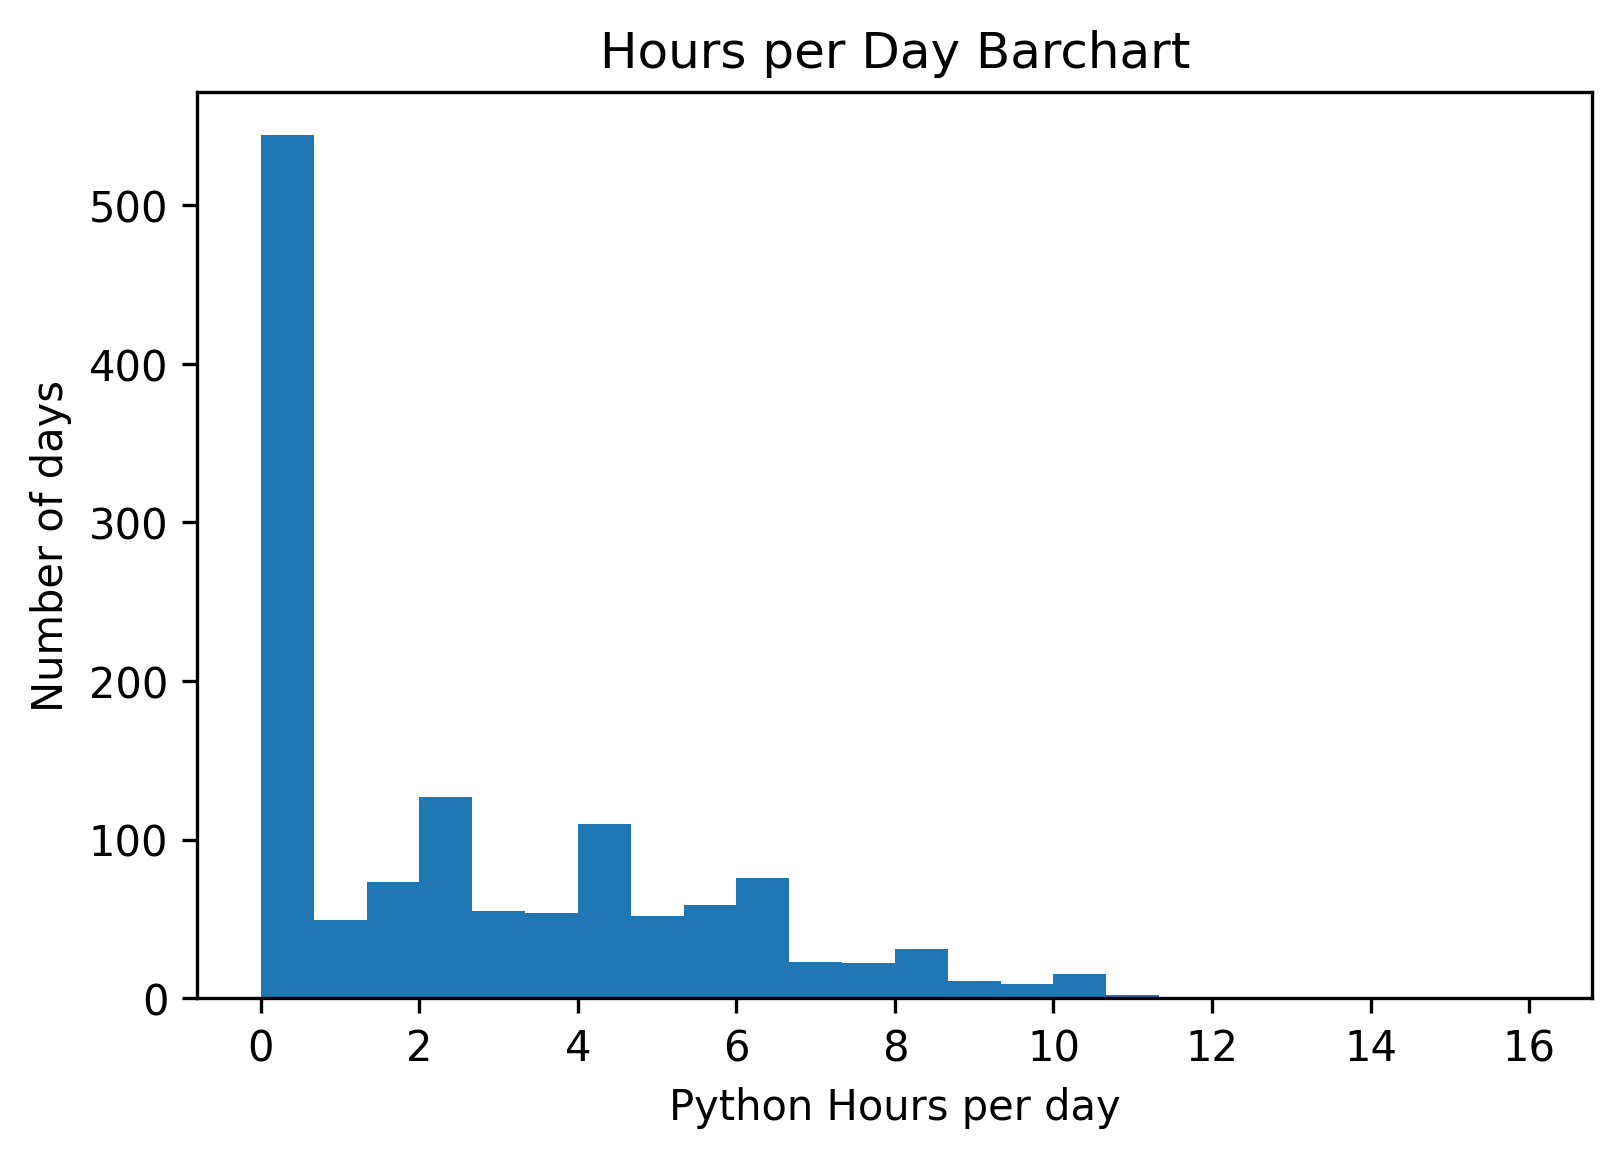

In [24]:
#Here we want to see the hours distribution 

fig, ax=plt.subplots(facecolor='white', dpi=300)
ax.hist(activity_divided,bins=24)
ax.set(xlabel='Python Hours per day',ylabel='Number of days',
       title='Hours per Day Barchart')
plt.show()

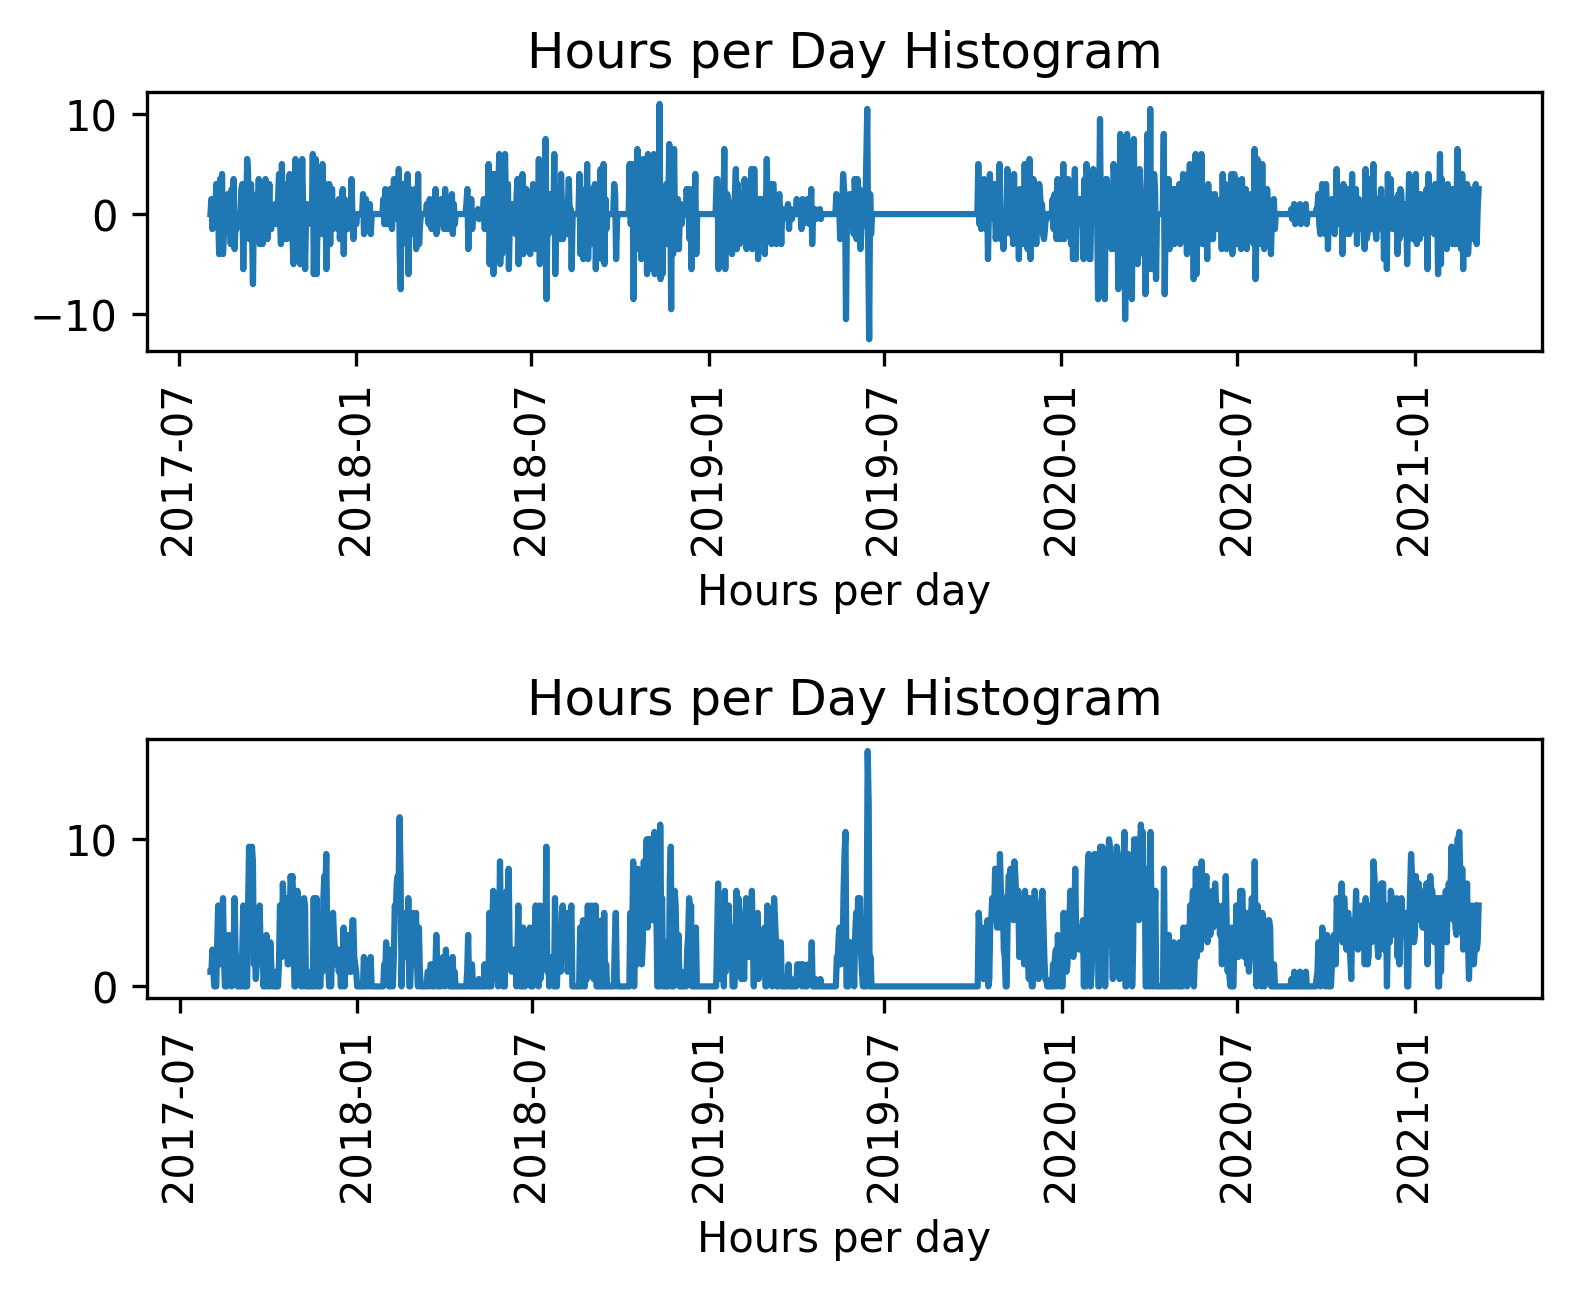

In [25]:
#we try to analyze the difference 
#in the total hours between adjacent days
#when it's positive we studied more the day after
#when it's negative we studied less the day after 

diff=activity_divided.diff().dropna()

fig, ax=plt.subplots(2,1,facecolor='white', dpi=300)
ax[0].plot(diff.index,diff)
ax[0].set(xlabel='Hours per day',title='Hours per Day Histogram')
plt.setp(ax[0].get_xticklabels(),rotation=90)
ax[1].plot(activity_divided.index,activity_divided)
ax[1].set(xlabel='Hours per day',title='Hours per Day Histogram')
plt.setp(ax[1].get_xticklabels(),rotation=90)
plt.subplots_adjust(hspace=1.5)
plt.show()

Diff Summary Statistics: 
 count    1314.000000
mean        0.003425
std         2.557821
min       -12.500000
25%        -1.000000
50%         0.000000
75%         1.000000
max        11.000000
Name: Activity, dtype: float64


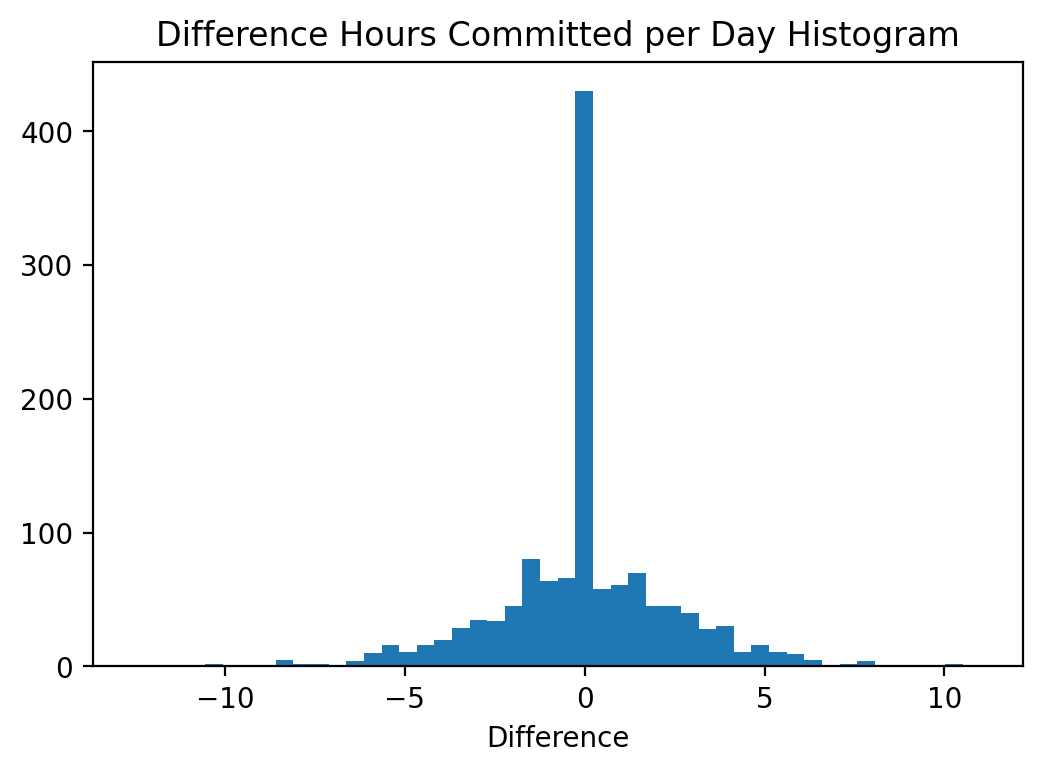

In [26]:
#here we plot the histogram of
#the difference between adiacent days in activity day 
print("Diff Summary Statistics: \n",diff.describe())
fig, ax=plt.subplots(facecolor='white', dpi=200)
ax.hist(diff,bins=48)
ax.set(xlabel='Difference',title='Difference Hours Committed per Day Histogram')
plt.show()

In [27]:
#we create 
#a normal distribution 
#with 
#mean equal to the average hours per day 
#std is calculated also on daily basis
n_mean=rs_df.Activity.divide(2).mean()
n_std=rs_df.Activity.divide(2).mean()
n_obj=scipy.stats.norm(n_mean, n_std).cdf(n_mean)
print(n_obj)

          
normal_obj=np.random.normal(n_mean, n_std,1000)
normal_sorted=sorted(normal_obj)
percentile=[2.5,25,50, 75,97.5]
percentile_100=[0.025,0.25,0.50, 0.75,0.975]
norm_ppf=scipy.stats.norm(n_mean, n_std).ppf(percentile_100)
print("Printng the Percent Point Distribution from ideal normal distribution:")
print(norm_ppf)
prc_array=np.percentile(normal_sorted,percentile)
print("Percentile array from a Normal Sampled Distribution \n", prc_array)
print(prc_array.size)
remaining_days=np.full(prc_array.size,remaining_h)
print("Year remaining to be an expert \n",(remaining_days/prc_array)/365)

0.5
Printng the Percent Point Distribution from ideal normal distribution:
[-2.4232703   0.82169679  2.5243346   4.22697242  7.4719395 ]
Percentile array from a Normal Sampled Distribution 
 [-2.78648085  0.82339701  2.63775365  4.41342466  7.61495503]
5
Year remaining to be an expert 
 [-6.56840678 22.22832911  6.93876007  4.14706065  2.40352565]


Some resources relative to:

1) Normal Distribution

2) Beta Distribution

3) PERT Distribution 

https://www.vosesoftware.com/riskwiki/Beta4distribution.php

https://it.wikipedia.org/wiki/Distribuzione_Beta

https://en.wikipedia.org/wiki/PERT_distribution

https://stats.stackexchange.com/questions/68983/beta-distribution-fitting-in-scipy

https://medium.com/w2hds/beta-distribution-what-when-how-c5ebaafdeedd

https://bizfluent.com/how-6722338-calculate-pert.html

https://math.stackexchange.com/questions/521575/difference-between-probability-and-probability-density

In [28]:
#in this section we identify autocorrelation for our time series
#
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [29]:
#Try to approximate the actual curve with polynomial features 
#Is a trivial way to make a prediction 
#Just for practice
#not for pratical use 
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.stattools import adfuller

In [30]:
print(rs_df.head(5))
print(today)

            Year  Month  Day  ...  sub_activity  Cum  Costant_CUM
Date                          ...                                
2017-08-02   2.0    2.0  2.0  ...           2.0  1.0            3
2017-08-03   2.0    2.0  2.0  ...           2.0  2.0            6
2017-08-04   5.0    5.0  5.0  ...           5.0  4.5            9
2017-08-05   2.0    2.0  2.0  ...           2.0  5.5           12
2017-08-06   0.0    0.0  0.0  ...           0.0  5.5           15

[5 rows x 12 columns]
2021-03-10 15:32:03.763785


In [31]:
degree=1
model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
x=np.arange(0,len(rs_df.index))
x=x[:,np.newaxis]
y=np.array(rs_df['Cum'].values)
y=y[:,np.newaxis]
print(len(x))
print(len(rs_df['Cum']))
print(len(x),x.shape)
print(len(y),y.shape)
fitted=model.fit(x,y)
x_pred=np.arange(0,len(rs_df.index)+365)
x_pred=x_pred[:,np.newaxis]
y_plot = model.predict(x_pred)
print(type(model))
print(type(fitted))
#we need to get another y pred 
#in order to evaluate 
#the residuals 
y_res=model.predict(x)
residuals=y_res-y
flat_residuals=residuals.flatten()
print(adfuller(flat_residuals))

1315
1315
1315 (1315, 1)
1315 (1315, 1)
<class 'sklearn.pipeline.Pipeline'>
<class 'sklearn.pipeline.Pipeline'>
(-0.9483556629308783, 0.7716316180430476, 14, 1300, {'1%': -3.435390199468821, '5%': -2.8637658312426035, '10%': -2.567955046745562}, 5649.437542979677)


In [32]:
#thorugh statsmodel ordinary least squared 
#we extract automatically residuals 
#and test if they are stationary or not 
import statsmodels.api as sm
#
X = sm.add_constant(x)
model_stat = sm.OLS(y,X)
results_stats = model_stat.fit()
print(results_stats.params)
#we test if residuals are stationary or not 
#with adfuller test
print(adfuller(results_stats.resid))

[-104.20491176    2.32824274]
(-0.9483556629309097, 0.7716316180430367, 14, 1300, {'1%': -3.435390199468821, '5%': -2.8637658312426035, '10%': -2.567955046745562}, 5649.43754297968)


[3804.91465361]
[2.26]


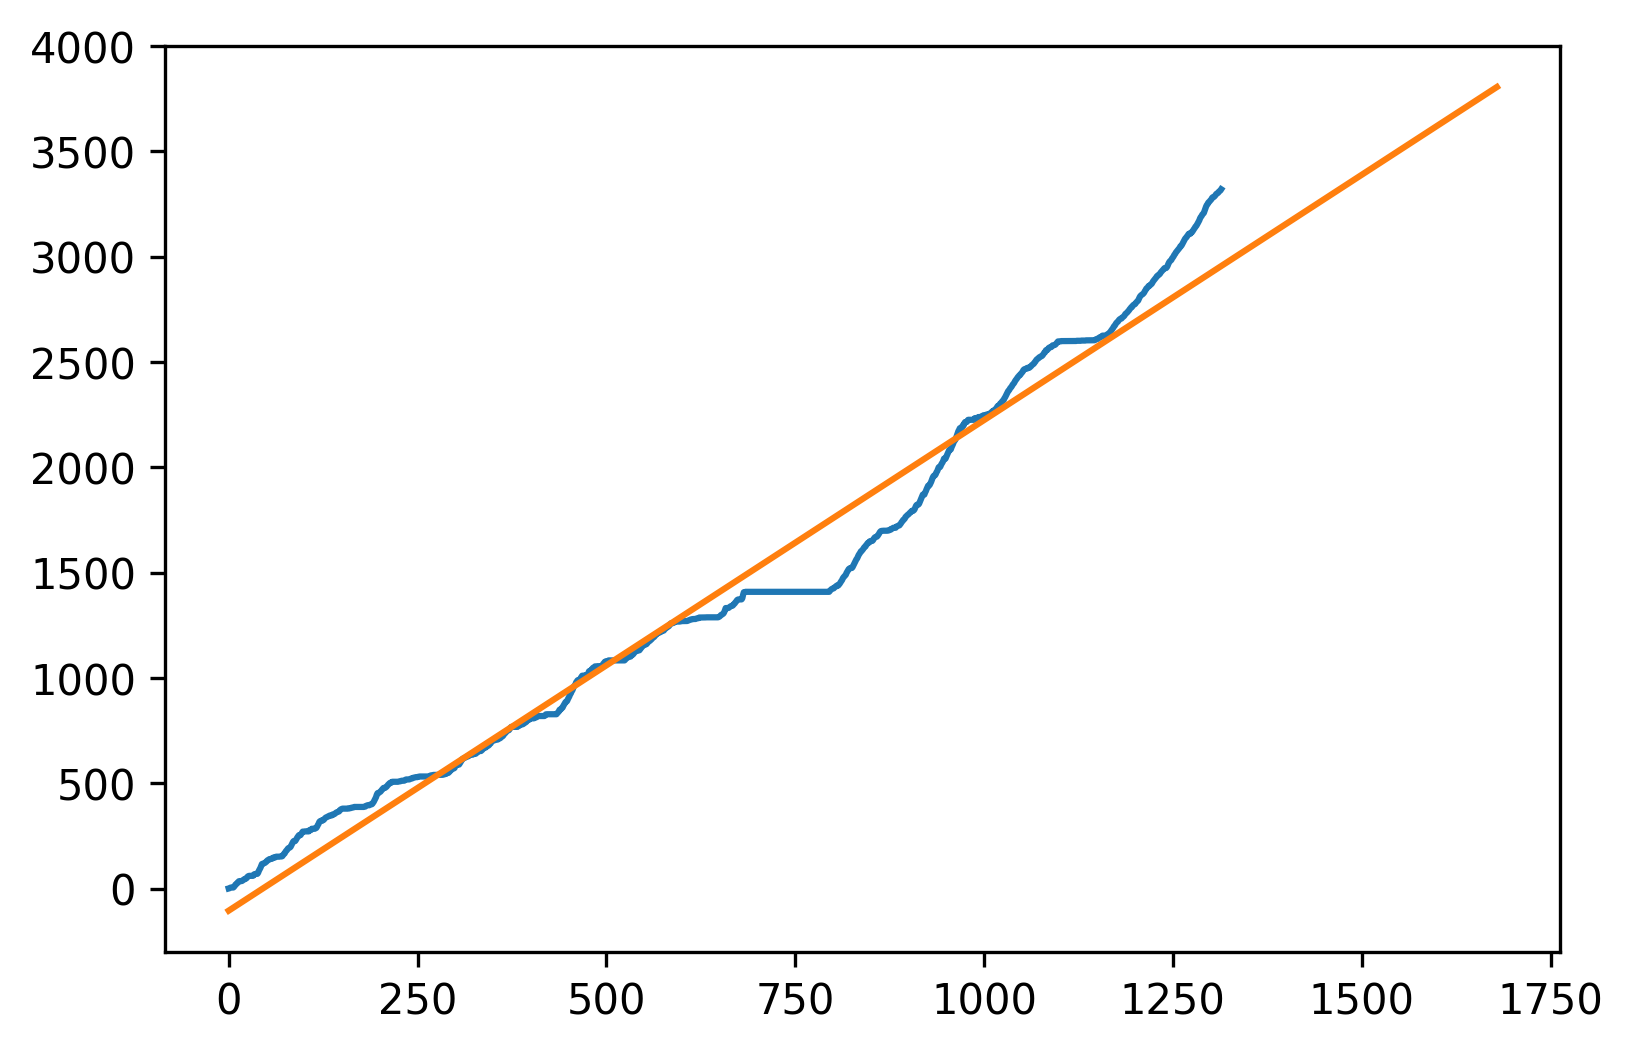

In [33]:
fig = plt.figure(facecolor='white', dpi=300)
ax = plt.axes()
ax.plot(x, y)
ax.plot(x_pred,y_plot)
print(y_plot[-1])
average=y_plot[-1]/len(y_plot)
print(np.round(average,2))

2.52


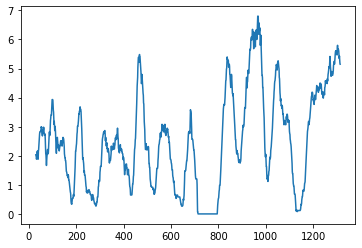

In [34]:
#Here we Analyze the moving average on a 30 days window 
week_moving_average=rs_df.Activity.divide(2).rolling(window=30).mean()
mean_activity=round(rs_df.Activity.divide(2).mean(),2)
print(mean_activity)
x_moving=np.arange(0,len(week_moving_average))
fig,ax=plt.subplots()
ax.plot(x_moving,week_moving_average)
plt.show()

In this section we try to undestand if the difference between daily records is stationary with ad adfuller test 

In [35]:

result=adfuller(diff)

print(result[0])
print("Adfuller p value:\n",np.round(result[1],4))

-15.242896994879432
Adfuller p value:
 0.0


# Forcasting Using Prophet 

In [36]:
#Importing Prophet
from fbprophet import Prophet

In [37]:
#Creating the dictonary that we will use to ingest data
activity_column=rs_df.Cum.iloc[:,]
date_column=rs_df.index
dict_series={'ds':date_column,'y':activity_column} 
#Creating the DataFrame that will be used as input for the 
#Prophet Model tuning 
prophet_df=pd.DataFrame(dict_series)

#Here we calculate the remaining days 
#to evaluate the how may days remain 
#at the end of the year 

#end of the year datetime 
end = datetime(datetime.today().year, 12, 31).date()
#today datetime 
today_datetime=today.date()
#
diff=(end-today_datetime).days
m = Prophet()
m.fit(prophet_df)
end_year=diff
future = m.make_future_dataframe(periods=diff)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#we should save the forecast containg in ds our evaluation day
last_forecast=forecast[['ds', 'yhat','yhat_lower',
                             'yhat_upper']].iloc[-1].copy()
print("Printing Last Forecast")
print(last_forecast)
print("Printing Tail")
print(forecast.tail())

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Printing Last Forecast
ds            2021-12-29 00:00:00
yhat                      4268.36
yhat_lower                 3539.3
yhat_upper                 5003.2
Name: 1610, dtype: object
Printing Tail
             ds        trend  ...  multiplicative_terms_upper         yhat
1606 2021-12-25  4319.582842  ...                         0.0  4252.784795
1607 2021-12-26  4323.123737  ...                         0.0  4256.003135
1608 2021-12-27  4326.664631  ...                         0.0  4259.968334
1609 2021-12-28  4330.205526  ...                         0.0  4264.192622
1610 2021-12-29  4333.746420  ...                         0.0  4268.363046

[5 rows x 19 columns]


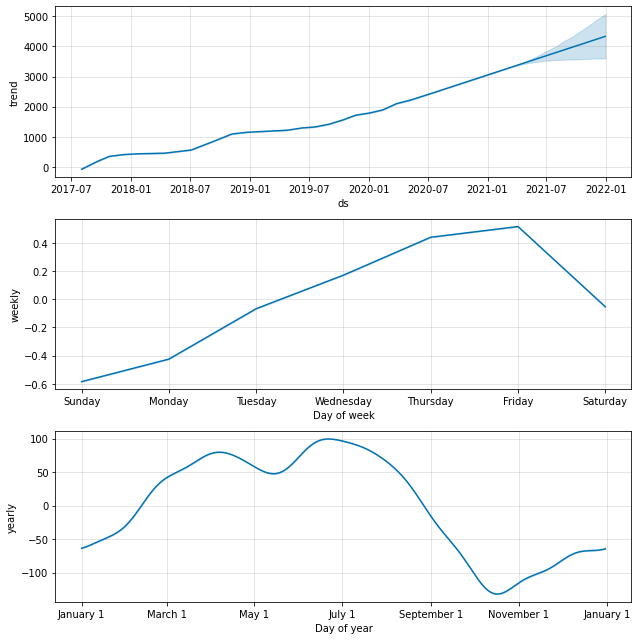

In [38]:
fig = m.plot_components(forecast)
plt.show()

### Forecasting a 5 year window using Prophet

ds            2027-03-07 00:00:00
yhat                      11087.5
yhat_lower               -4566.98
yhat_upper                27223.7
Name: 3504, dtype: object



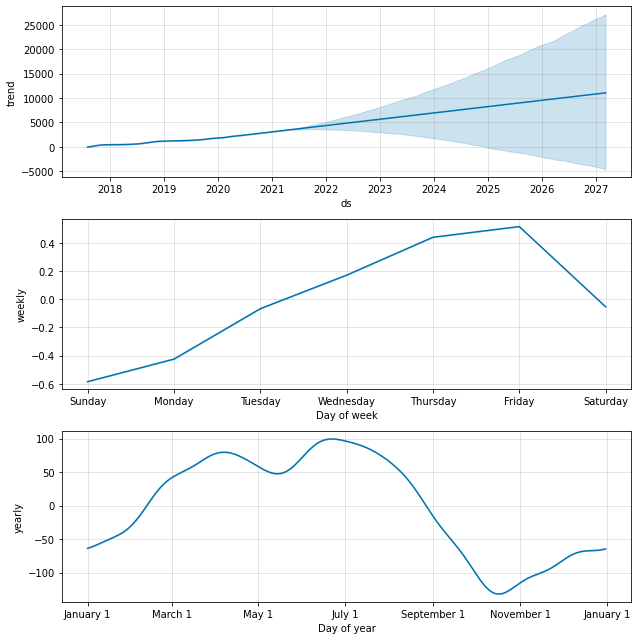

In [39]:
six_yw=365*6
future_6 = m.make_future_dataframe(periods=six_yw)
forecast_6 = m.predict(future_6)
forecast_6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#we should save the forecast containg in ds our evaluation day
last_forecast_6=forecast_6[['ds', 'yhat','yhat_lower',
                             'yhat_upper']].iloc[-1].copy()
print(last_forecast_6)
print()
fig = m.plot_components(forecast_6)
plt.show()

##Forecasting 2021

298
1315   2021-03-09
1316   2021-03-10
1317   2021-03-11
1318   2021-03-12
1319   2021-03-13
          ...    
1608   2021-12-27
1609   2021-12-28
1610   2021-12-29
1611   2021-12-30
1612   2021-12-31
Name: ds, Length: 298, dtype: datetime64[ns]


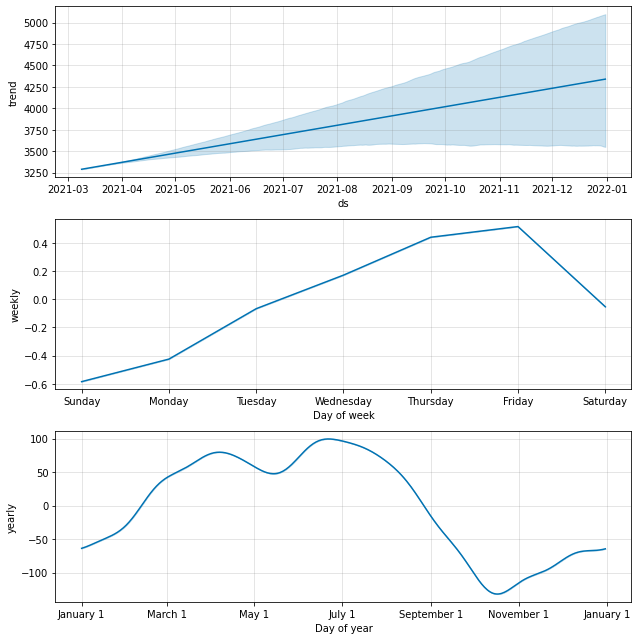

In [40]:
forecast2021=forecast_6[(forecast_6['ds']<'2022')&(forecast_6['ds']>rs_df.index[-1])]
print(len(forecast2021.index))
print((forecast2021.ds))
fig = m.plot_components(forecast2021)
plt.show()

In [41]:

print(forecast2021[['ds',"yhat_upper","yhat"]].tail())
forecast2021=forecast2021.assign(Costant=int(rs_df['Cum'][-1]))
print(forecast2021[['ds',"yhat_upper","yhat",'Costant']].tail())

forecast2021=forecast2021[['ds',"yhat_upper","yhat",'Costant']]

             ds   yhat_upper         yhat
1608 2021-12-27  5001.798589  4259.968334
1609 2021-12-28  5015.962063  4264.192622
1610 2021-12-29  5020.432982  4268.363046
1611 2021-12-30  5026.815503  4272.632665
1612 2021-12-31  5040.049304  4276.778155
             ds   yhat_upper         yhat  Costant
1608 2021-12-27  5001.798589  4259.968334     3319
1609 2021-12-28  5015.962063  4264.192622     3319
1610 2021-12-29  5020.432982  4268.363046     3319
1611 2021-12-30  5026.815503  4272.632665     3319
1612 2021-12-31  5040.049304  4276.778155     3319


In [42]:
for i in range(len(x_days)): 
  print(x_days[i])

2017-08-02 00:00:00
2018-11-11 00:00:00
2020-02-28 00:00:00
2021-03-08 00:00:00


In [43]:
two_ths=rs_df[rs_df['Cum']>=1500]
first_quarter=forecast2021[forecast2021.ds<"31/03/2021"].iloc[-1]
second_quarter=forecast2021[forecast2021.ds<"30/06/2021"].iloc[-1]
third_quarter=forecast2021[forecast2021.ds<"30/09/2021"].iloc[-1]
fourth_quarter=forecast2021[forecast2021.ds<"31/12/2021"].iloc[-1]
print("First Second Third Fourth Quarter:")
print(first_quarter)
print(second_quarter)
print(third_quarter)
print(fourth_quarter)
quarter_forecast=[first_quarter.ds,second_quarter.ds,
                third_quarter.ds,fourth_quarter.ds]
quarter_values=[ first_quarter.yhat,second_quarter.yhat,
                third_quarter.yhat,fourth_quarter.yhat]                
x_vec=[x_days[2],x_days[3],
                first_quarter.ds,second_quarter.ds,
                third_quarter.ds,fourth_quarter.ds]
y_vec=[rs_df[rs_df.index==x_days[2]]['Cum'].values,
       rs_df[rs_df.index==x_days[3]]['Cum'].values,
       first_quarter.yhat,second_quarter.yhat,
                third_quarter.yhat,fourth_quarter.yhat]
y_vec_r=[int(x) for x in y_vec]
quarter=["First Quarter","Second Quarter","Third Quarter","Fourth Quarter"]
#x_days=[rs_df.index[0],first_thous.index[0],second_thous.index[0],rs_df.index[-1]]
#x_days_label=[x.strftime("%d/%m/%Y") for x in x_days]
#               
print("XVec",x_vec,"\n")
print('YVec',y_vec_r,"\n")
print(quarter,"\n")
print(quarter_forecast,"\n")

#quarter_label=[str(quarter[x]+'\n'+y.strftime("%d/%m/%Y")) for x,y in [quarter, quarter_forecast]]
quarter_label=[q+'\n'+qf.strftime("%d/%m/%Y") for q,qf in zip(quarter,quarter_forecast)]
print("\n",quarter_label,"\n")
print(quarter_forecast)
printing=[print(s) for s in quarter_label ]

First Second Third Fourth Quarter:
ds            2021-03-30 00:00:00
yhat_upper                3452.54
yhat                      3439.54
Costant                      3319
Name: 1336, dtype: object
ds            2021-06-29 00:00:00
yhat_upper                3953.88
yhat                      3783.07
Costant                      3319
Name: 1427, dtype: object
ds            2021-09-29 00:00:00
yhat_upper                4355.79
yhat                      3915.81
Costant                      3319
Name: 1519, dtype: object
ds            2021-12-30 00:00:00
yhat_upper                5026.82
yhat                      4272.63
Costant                      3319
Name: 1611, dtype: object
XVec [Timestamp('2020-02-28 00:00:00', freq='D'), Timestamp('2021-03-08 00:00:00', freq='D'), Timestamp('2021-03-30 00:00:00'), Timestamp('2021-06-29 00:00:00'), Timestamp('2021-09-29 00:00:00'), Timestamp('2021-12-30 00:00:00')] 

YVec [2000, 3319, 3439, 3783, 3915, 4272] 

['First Quarter', 'Second Quarter', 'Thir

['02/08/2017', '11/11/2018', '28/02/2020', '08/03/2021']
[1500 1500 1500 1500]
[Timestamp('2021-04-04 00:00:00'), Timestamp('2021-07-04 00:00:00'), Timestamp('2021-10-04 00:00:00'), Timestamp('2022-01-04 00:00:00')]
[3439.536868685082, 3783.069192218177, 3915.8098271589392, 4272.6326650933925]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



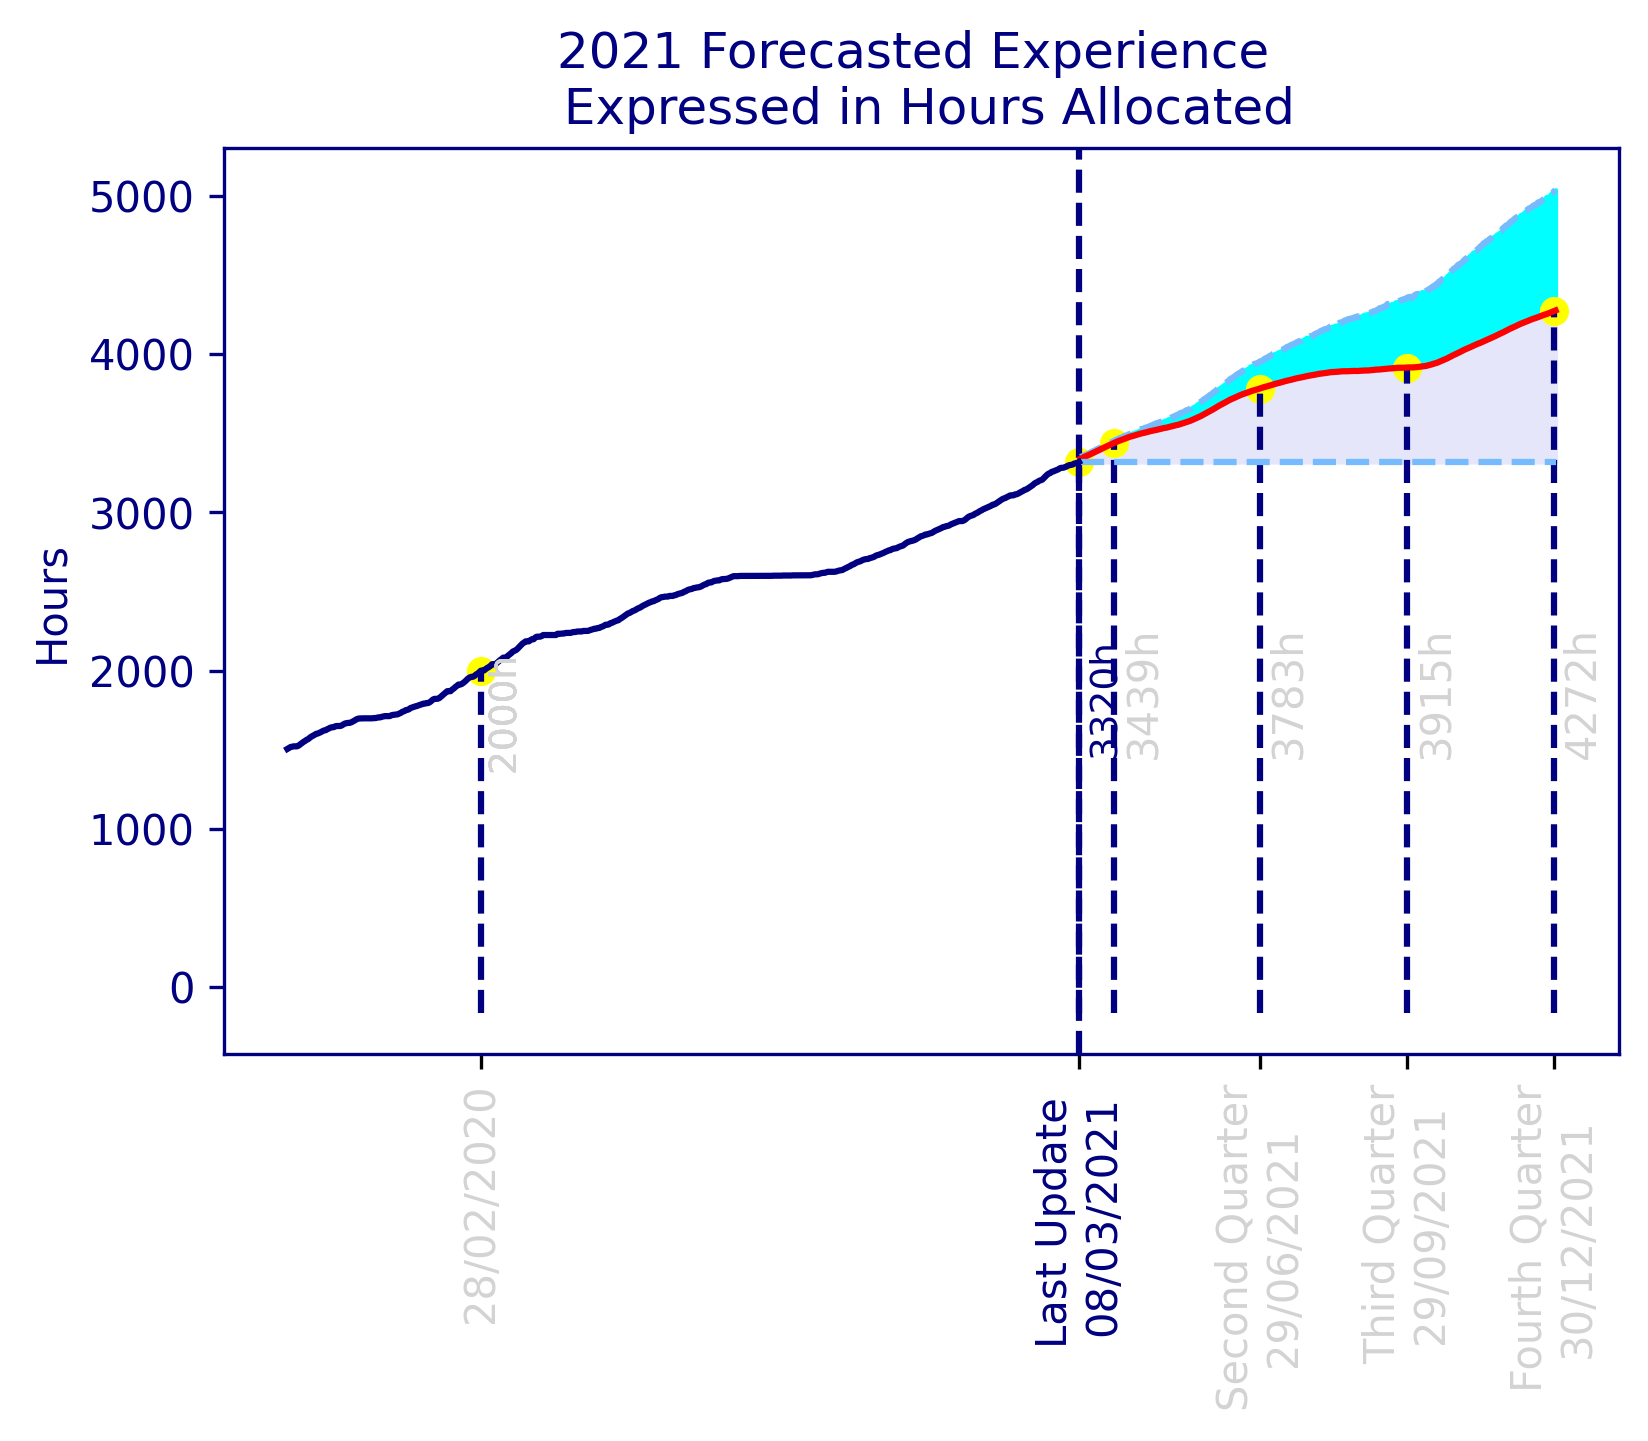

In [49]:

def marker_function(x_ax,y_ax,color_choice='yellow'):
  marker=plt.scatter(x_ax,y_ax,color=color_choice,marker="o") 
  return marker


offset=timedelta(days=5)
fig3, ax3= plt.subplots(figsize=(6,4),
                          facecolor='white', dpi=300)


print(x_days_label)


plt.axvline(rs_df.index[-1],linestyle="dashed",color='navy')
ax3.plot(forecast2021.ds,forecast2021.yhat_upper,linestyle='dashed',color="#75bbfd")
ax3.plot(forecast2021.ds,forecast2021.yhat,color="red")
ax3.plot(forecast2021.ds,forecast2021.Costant,linestyle='dashed',color="#75bbfd")
ax3.plot(two_ths.index,two_ths['Cum'],color='navy')
ax3.set_xticks([x_days[2],x_days[3],
                #first_quarter.ds,
                second_quarter.ds,
                third_quarter.ds,fourth_quarter.ds])
ax3.tick_params(axis='y', colors='navy')
ax3.set_xticklabels([x_days_label[2],
                     "Last Update \n{}".format(x_days_label[-1]),
                     #quarter_label[0],
                     quarter_label[1],
                     quarter_label[2],
                     quarter_label[3]], 
                    rotation=90,
                    color="lightgrey")#
#
#ax2.set_yticklabels(color="navy")
ax3.set_title('2021 Forecasted Experience \n Expressed in Hours Allocated',color="navy")
ax3.fill_between(forecast2021.ds,forecast2021.Costant, forecast2021.yhat,color='lavender')
ax3.fill_between(forecast2021.ds,forecast2021.yhat_upper, forecast2021.yhat,color='aqua')
ax3.set_ylabel("Hours",color='navy')
ax3.vlines(x=x_vec,ymin=ax2.get_ylim()[0],
           ymax=y_vec,linestyle="dashed",color='navy')
#text=plt.text(x_days[1],mid,'1000h',fontsize=9,rotation=90,
#              color="lightgrey"
#             )
#text2=plt.text(x_days[2],mid,'2000h ',fontsize=9,rotation=90,
#               color="lightgrey")
#text2=plt.text(x_days[-1],mid,"{}h".format(progress),fontsize=9,rotation=90,
#               color="navy")
text2=plt.text(x_days[2]+timedelta(days=4.5),1400,'2000h ',fontsize=9,rotation=90,
               color="lightgrey")
#forecast_notation(quarter_forecast,1500,offset,quarter_values,cl='red')
#first_quarter_projection note
first_quarter_projection=plt.text(x_days[2]+timedelta(days=4.5),1400,'2000h ',fontsize=9,rotation=90,
               color="lightgrey")
#second_quarter_projection note
second_quarter_projection=plt.text(x_days[2]+timedelta(days=4.5),1400,'2000h ',fontsize=9,rotation=90,
               color="lightgrey")
#third_quarter_projection note
third_quarter_projection=plt.text(x_days[2]+timedelta(days=4.5),1400,'2000h ',fontsize=9,rotation=90,
               color="lightgrey")
#fourth_quarter_projection note
fourth_quarter_projection=plt.text(x_days[2]+timedelta(days=4.5),1400,'2000h ',fontsize=9,rotation=90,
               color="lightgrey")
ax3.scatter(x_vec,y_vec,color="yellow",marker="o")
ax3.spines['bottom'].set_color('navy')
ax3.spines['top'].set_color('navy') 
ax3.spines['right'].set_color('navy')
ax3.spines['left'].set_color('navy')

#marker_function(x_vec,y_vec_r)
#quarter_forecast,1500,offset,quarter_values,cl='red'
yy=np.full(len(quarter_forecast),1500)
print(yy)
x_off=[xx+offset for xx in quarter_forecast]
print(x_off) 
int_quarter_values=[int(x) for x in quarter_values]
str_quarter_values=["{}h".format(hh) for hh in int_quarter_values]
print(quarter_values)
for x_,y_,z_ in zip(x_off,yy,str_quarter_values):
  plt.text(x_,y_,z_,color='lightgrey',rotation=90)
text_updtate=plt.text(x_days[-1]+offset,1500,"{}h".format(progress),fontsize=9,rotation=90,
               color="navy")

#plt.text(x_off,yy,int_quarter_values,color='red')
plt.gca().get_xticklabels()[1].set_color('navy')

 
plt.show()


In [45]:
rs_month=rs_df.resample('M').sum()
print(rs_month.tail())

             Year  Month    Day  ...  sub_activity      Cum  Costant_CUM
Date                             ...                                    
2020-11-30  262.0  262.0  262.0  ...         262.0  83580.5       108225
2020-12-31  258.0  258.0  258.0  ...         258.0  90387.5       114669
2021-01-31  301.0  301.0  301.0  ...         301.0  94937.0       117552
2021-02-28  317.0  317.0  317.0  ...         317.0  90157.5       108654
2021-03-31   60.0   60.0   60.0  ...          60.0  26450.5        31476

[5 rows x 12 columns]


In [46]:
print(pythondf_raw.head())
print(len(set(pythondf_raw['sub_activity'])))
python_g=pythondf_raw.groupby('sub_activity').count().sort_values(by='main_activity',ascending=False)
print(python_g.head(40))
print(python_g.tail(30))

      Year  Month  Day  ...       Date main_activity  sub_activity
3067  2017      8    2  ... 2017-08-02      +Python       datacamp
3068  2017      8    2  ... 2017-08-02      +Python       datacamp
3069  2017      8    3  ... 2017-08-03      +Python       datacamp
3070  2017      8    3  ... 2017-08-03      +Python       datacamp
3071  2017      8    4  ... 2017-08-04      +Python       datacamp

[5 rows x 11 columns]
80
                                                    Year  ...  main_activity
sub_activity                                              ...               
datacamp                                             592  ...            592
Lolacupcakes @work                                   533  ...            533
kaggle @aceacompetition                              473  ...            473
progetti                                             351  ...            351
bokeh @Lolacupcakes @timeseries @work                335  ...            335
aws @nsg @innlab                 

Text(0.0, 1.0, "It's a long way to the Top\n if you want master the code")

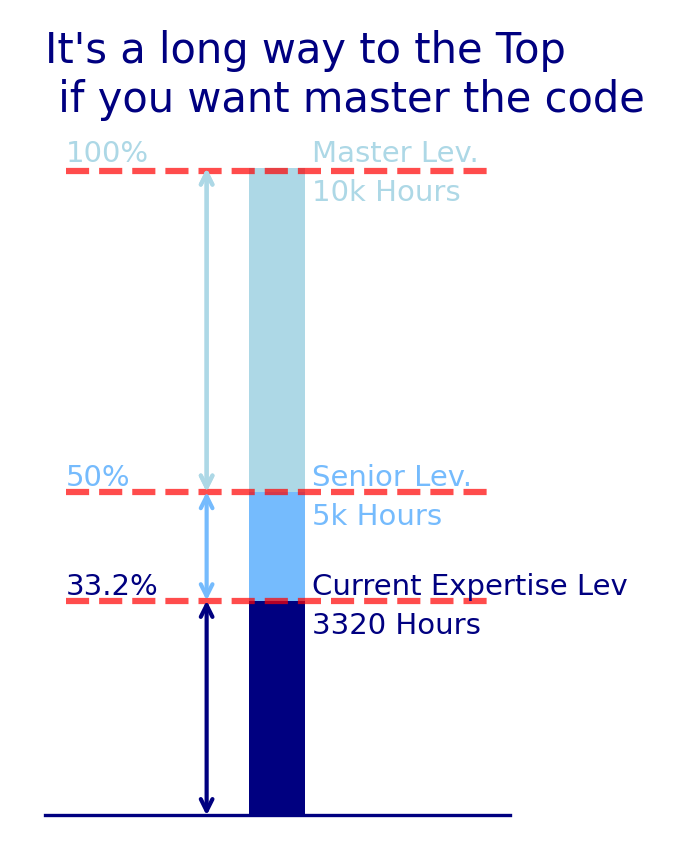

In [47]:
#creating a stacked barplot for experience
#rembember h is the 10.000 variable

fig3, ax3= plt.subplots(figsize=(2,3),
                          facecolor='white', dpi=300)
plt.bar(1,h,color="lightblue")
plt.bar(1,h/2,color="#75bbfd")
plt.bar(1,progress,color="navy")
x1=[-2,-1,2,3,4]
y1=[h,h,h,h,h]
x3=x1
y3=[x/2 for x in y1]
pad=h*0.01
prog_per=round(progress/10000*100,1)
plt.hlines(h-40,x1[0],x1[-1],alpha=0.7,linestyle="dashed",color="red")
plt.hlines(y3[0],x1[0],x1[-1],alpha=0.7,linestyle="dashed",color="red")
plt.hlines(progress,x1[0],x1[-1],alpha=0.7,linestyle="dashed",color="red")
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.spines['bottom'].set_color('navy')
ax3.spines['top'].set_color('white') 
ax3.spines['right'].set_color('white')
ax3.spines['left'].set_color('white')
ax3.tick_params(axis='x', colors='white')
ax3.tick_params(axis='y', colors='white')
#current expertise level
plt.text(1.5,progress+pad,'Current Expertise Lev',
         fontsize=7,color="navy")
#current value
plt.text(1.5,progress-5*pad,'{} Hours'.format(progress),
         fontsize=7,color="navy")
#master level
plt.text(1.5,h+pad,'Master Lev.',
         fontsize=7,color="lightblue")
#master value
plt.text(1.5,h-5*pad,'10k Hours',
         fontsize=7,color="lightblue")
#senior level
plt.text(1.5,h/2+pad,'Senior Lev.',
         fontsize=7,color="#75bbfd")
#senior value
plt.text(1.5,h/2-5*pad,'5k Hours',
         fontsize=7,color="#75bbfd")
annotation2=plt.annotate('', xy  = (0, h/2),  
    xycoords = 'data', \
    xytext = (0, h), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='lightblue', arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)                 
txt1=plt.text(-2,progress+pad,'{}%'.format(prog_per),
         fontsize=7,color="navy")
txt2=plt.text(-2,h/2+pad,'50%',
         fontsize=7,color="#75bbfd")
txt3=plt.text(-2,h+pad,'100%',
         fontsize=7,color="lightblue")

annotation2=plt.annotate('', xy  = (0, h/2),  
    xycoords = 'data', \
    xytext = (0, h), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='lightblue', arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)                 
annotation3=plt.annotate('', xy  = (0, progress),  
    xycoords = 'data', \
    xytext = (0, h/2), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor="#75bbfd", arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)                 
annotation4=plt.annotate('', xy  = (0, 0),  
    xycoords = 'data', \
    xytext = (0, progress), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='navy', arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)           
ax3.set_title("It's a long way to the Top\n if you want master the code",loc="left",fontsize=10,color='navy' )      

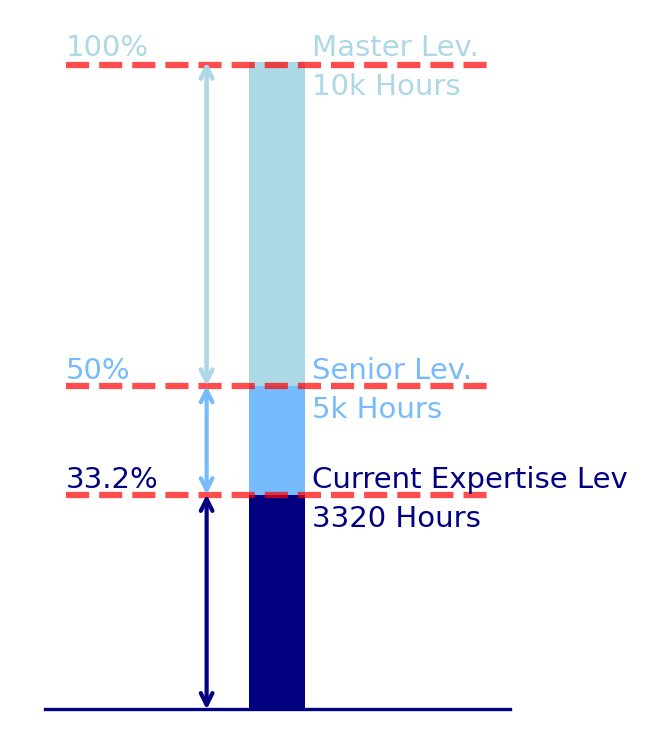

In [48]:
#creating a stacked barplot for experience
#---->rembember h is the 10.000 variable<----

fig3, ax3= plt.subplots(figsize=(2,3),
                          facecolor='white', dpi=300)
plt.bar(1,h,color="lightblue")
plt.bar(1,h/2,color="#75bbfd")
plt.bar(1,progress,color="navy")
x1=[-2,-1,2,3,4]
y1=[h,h,h,h,h]
x3=x1
y3=[x/2 for x in y1]
pad=h*0.01
prog_per=round(progress/10000*100,1)
plt.hlines(h-40,x1[0],x1[-1],alpha=0.7,linestyle="dashed",color="red")
plt.hlines(y3[0],x1[0],x1[-1],alpha=0.7,linestyle="dashed",color="red")
plt.hlines(progress,x1[0],x1[-1],alpha=0.7,linestyle="dashed",color="red")
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.spines['bottom'].set_color('navy')
ax3.spines['top'].set_color('white') 
ax3.spines['right'].set_color('white')
ax3.spines['left'].set_color('white')
ax3.tick_params(axis='x', colors='white')
ax3.tick_params(axis='y', colors='white')
#current expertise level
plt.text(1.5,progress+pad,'Current Expertise Lev',
         fontsize=7,color="navy")
#current value
plt.text(1.5,progress-5*pad,'{} Hours'.format(progress),
         fontsize=7,color="navy")
#master level
plt.text(1.5,h+pad,'Master Lev.',
         fontsize=7,color="lightblue")
#master value
plt.text(1.5,h-5*pad,'10k Hours',
         fontsize=7,color="lightblue")
#senior level
plt.text(1.5,h/2+pad,'Senior Lev.',
         fontsize=7,color="#75bbfd")
#senior value
plt.text(1.5,h/2-5*pad,'5k Hours',
         fontsize=7,color="#75bbfd")
annotation2=plt.annotate('', xy  = (0, h/2),  
    xycoords = 'data', \
    xytext = (0, h), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='lightblue', arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)                 
txt1=plt.text(-2,progress+pad,'{}%'.format(prog_per),
         fontsize=7,color="navy")
txt2=plt.text(-2,h/2+pad,'50%',
         fontsize=7,color="#75bbfd")
txt3=plt.text(-2,h+pad,'100%',
         fontsize=7,color="lightblue")

annotation2=plt.annotate('', xy  = (0, h/2),  
    xycoords = 'data', \
    xytext = (0, h), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='lightblue', arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)                 
annotation3=plt.annotate('', xy  = (0, progress),  
    xycoords = 'data', \
    xytext = (0, h/2), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor="#75bbfd", arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)                 
annotation4=plt.annotate('', xy  = (0, 0),  
    xycoords = 'data', \
    xytext = (0, progress), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='navy', arrowstyle = '<->', shrinkA = 0, shrinkB = 0),)           